# Аналитика развлекательного приложения:

Мы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Бизнес несет убытки, несмотря на большие вливания в привлечение пользователей. Необходимо понять, почему так происходит и как можно этого избежать. У нас есть данные о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

В ходе выполнения анализа нам предстоит сделать следующее:

1) Загрузить данные и привести их в вид, подходящий для анализа

2) Cоздать собственные функции для рассчета и визуализации LTV, ROI, удержания и конверсии
 
3) Выяснить:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

4) Проанализировать общую окупаемость рекламы и окупаемость с разбивкой по устройствам, странам и рекламным каналам

При решении этого шага будем считать, что смотрим данные 1-го ноября 2019 года и, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

5) Выявить проблемы окупаемости и постараться объяснить причины их возникновения. Дать рекомендации для отдела маркетинга для повышения эффективности




# Шаг 1. Загружаем данные и готовим их к анализу

Для работы с данными нам нужно импортировать библиотеки, которые понадобятся нам для дальнейшей работы.

In [1]:
# импорт библиотеки pandas
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# чтение файлов с данными и сохранение их в переменных
visits =pd.read_csv('/datasets/visits_info_short.csv')
orders =pd.read_csv('/datasets/orders_info_short.csv')
costs =pd.read_csv('/datasets/costs_info_short.csv')

Создадим собственную функцию для получения общей информации о датасете.

In [3]:
#создаем собственную функцию
def inform(dt):
    display(dt.head(5))
    print('\n'*2)
    dt.info()
    print('\n'*2)
    display(dt.describe())
    print('\n'*2)
    print(f'Количество дубликатов {dt.duplicated().sum()}')

In [4]:
#получаем общую информацию о датасете
inform(visits)

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB





User Id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11




Количество дубликатов 0


Мы видим, что пропусков в датасете нет. Однако в столбце есть другая проблема - типы данных в столбцах Session Start и Session End нужно будет привести в удобный для работы Python формат datetime. Также названия столбцев не соответствуют правилам хорошего стиля.

In [5]:
#переименовываем столбцы
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]

In [6]:
#меняем формат данных
visits['session_start'] = pd.to_datetime( visits['session_start']) 
visits['session_end'] = pd.to_datetime( visits['session_end'])

Теперь посмотрим на результат проделанной работы

In [7]:
#получаем общую информацию о датасете
inform(visits)

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB





user_id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11




Количество дубликатов 0


Типы данных приведены в нужный формат, а названия столбцев приведены к хорошему стилю. Поскольку пропусков в датасете нет, дубликатов тоже нет.

Согласно документации к данным, таблица visits хранит информацию о посещениях сайта. В ней 6 столбцев:

**`user_id`** — уникальный идентификатор пользователя

**`device`** — категория устройства пользователя

**`session_start`** — дата и время начала сессии

**`session_end`** — дата и время окончания сессии

**`channel`** — идентификатор рекламного источника, из которого пришел пользователь

**`region`** - страна пользователя

**Теперь перейдем к другой таблице.**

In [8]:
#получаем общую информацию о датасете
inform(orders)

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB





User Id       Revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000




Количество дубликатов 0


Пропусков в датасете нет, формат данных в столбце Event Dt нужно привести в норму. Столбцы нужно будет привести к хорошему стилю. Дубликатов в датасете нет.

In [9]:
#переименовываем столбцы
orders.columns = ['user_id', 'event_dt', 'revenue'] 

In [10]:
#меняем формат данных
orders['event_dt'] = pd.to_datetime(orders['event_dt']) 

In [11]:
#получаем общую информацию о датасете
inform(orders)

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB





user_id       revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000




Количество дубликатов 0


Теперь таблица готова к работе с данными - пропусков нет, дубликатов нет, стиль столбцев в норме, формат данных тоже приведен в норму.

Согласно документации к данным, таблица orders хранит информацию о заказах. В ней 3 столбца:

**`user_id`** — уникальный id пользователя, который сделал заказ

**`event_dt`** — дата и время покупки

**`revenue`** — выручка

**Теперь перейдем к другой таблице.**

In [12]:
#получаем общую информацию о датасете
inform(costs)

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB





costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000




Количество дубликатов 0


Пропусков в датасете нет, формат данных в столбце dt нужно привести в норму. Столбцы нужно будет привести к хорошему стилю. Дубликатов в датасете нет.

In [13]:
#переименовываем столбцы
costs.columns = ['dt', 'channel', 'costs'] 

In [14]:
#меняем формат данных
costs['dt'] = pd.to_datetime(costs['dt']) 

In [15]:
#получаем общую информацию о датасете
inform(costs)

dt   channel  costs
0 2019-05-01  FaceBoom  113.3
1 2019-05-02  FaceBoom   78.1
2 2019-05-03  FaceBoom   85.8
3 2019-05-04  FaceBoom  136.4
4 2019-05-05  FaceBoom  122.1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB





costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000




Количество дубликатов 0


Теперь таблица готова к работе с данными - пропусков нет, дубликатов нет, стиль столбцев в норме, формат данных тоже приведен в норму.

Согласно документации к данным, таблица orders хранит информацию о затратах на маркетинг. В ней 3 столбца:

**`channel`** — идентификатор рекламного источника

**`dt`** — дата

**`costs`** — затраты на этот рекламный источник в этот день

# Шаг 2. Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии


## Функция для определения профилей пользователе

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
           {'session_start': 'first', 'session_end': 'first', 'device': 'first', 'channel': 'first', 'region': 'first'}
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )


    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].astype('datetime64[D]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    new_users['dt'] = pd.to_datetime(new_users['dt']).astype('datetime64[D]')

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

## Функция для определения конверсии

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    conversion_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    conversion_raw = conversion_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    conversion_raw['lifetime'] = (
        conversion_raw['event_dt'] - conversion_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    conversion_grouped = group_by_dimensions(conversion_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    conversion_in_time = group_by_dimensions(
        conversion_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return conversion_raw, conversion_grouped, conversion_in_time 

## Функция для определения удержания пользователей

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

## Функцию для определения LTV, CAC и ROI пользователей.

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases, on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для дальнейшей работы с данными созданы. Можно приступать к следующему шагу.

# Шаг 3. Проводим исследовательский анализ данных

Тепер нам нужно построить профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Также нам необходимо выяснить:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Построим профили пользователей с помощью полученной ранее функции.

In [20]:
#применяем полученную функцию для создания нового датасета
profiles = get_profiles(visits, orders, costs)
#выводим первые 5 строк датасета на экран
profiles.head()

user_id            first_ts         session_end  device     channel  \
0    599326 2019-05-07 20:58:57 2019-05-07 21:11:36     Mac    FaceBoom   
1   4919697 2019-07-09 12:46:07 2019-07-09 14:44:32  iPhone    FaceBoom   
2   6085896 2019-10-01 09:58:33 2019-10-01 12:30:18  iPhone     organic   
3  22593348 2019-08-22 21:35:48 2019-08-22 21:52:45      PC  AdNonSense   
4  31989216 2019-10-02 00:07:44 2019-10-02 00:20:52  iPhone     YRabbit   

          region         dt      month  payer  acquisition_cost  
0  United States 2019-05-07 2019-05-01   True          1.088172  
1  United States 2019-07-09 2019-07-01  False          1.107237  
2         France 2019-10-01 2019-10-01  False          0.000000  
3        Germany 2019-08-22 2019-08-01  False          0.988235  
4  United States 2019-10-02 2019-10-01  False          0.230769

Определим минимальную и максимальную дату привлечения пользователей.

In [21]:
print(f'Минимальная дата привлечения пользователей: {profiles["dt"].min()}')
print(f'Максимальная дата привлечения пользователей: {profiles["dt"].max()}')
      

Минимальная дата привлечения пользователей: 2019-05-01 00:00:00
Максимальная дата привлечения пользователей: 2019-10-27 00:00:00


Это совпадает с документацией к данным. Получается, что минимум и максимум соответсвуют пределам периода, за который мы имеем даные, а именно с 2019-05-01 по 2019-10-27.

## Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

Теперь нужно выяснить, из каких стран приходят посетители, и какие страны дают больше всего платящих пользователей. 

Чтобы узнать, из каких стран приходили пользователи, сгруппируем данные по странам и посчитаем для каждой страны количество посетителей.

In [22]:
#считаем количество посетителей для каждой страны
profiles.groupby('region').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False)

user_id
region                
United States   100002
UK               17575
France           17450
Germany          14981

Так же для наглядности построим график, отображающий динамику привлечения новых пользователей по каждой из стран.

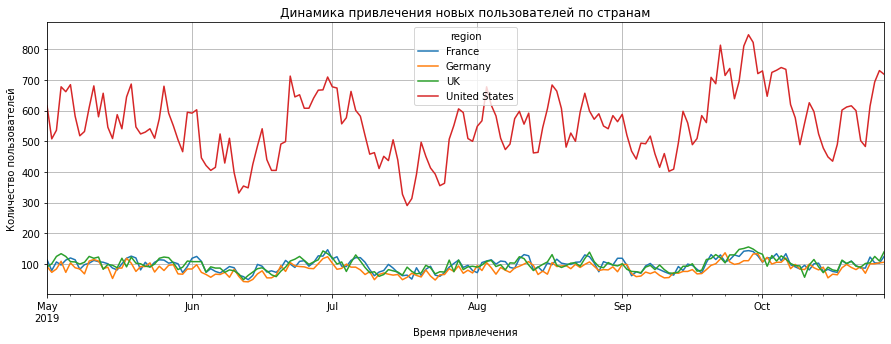

In [23]:
#строим график динамики привлечения пользователей из разных стран
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='region',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title("Динамика привлечения новых пользователей по странам")
plt.xlabel("Время привлечения")
plt.ylabel("Количество пользователей")
plt.show()

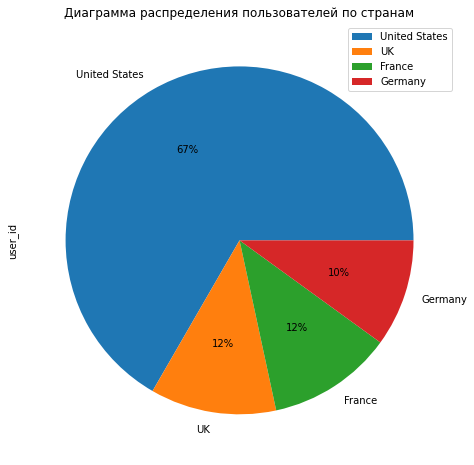

In [24]:
#строим круговую диаграмму для пользователей, привлеченных из разных стран
profiles.groupby('region').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False).plot(y = 'user_id', kind='pie', figsize =(8,8), autopct='%.0f%%') 
plt.title("Диаграмма распределения пользователей по странам")
plt.show()

Мы видим, что посетители, исходя из имеющихся данных, приходили из 4 стран: США, Великобритании, Франции и Германии. Больше всего посетителей было привлечено из США, а меньше же всего - из Германии.

Теперь вычислим, какие страны дают нам больше всего платящих пользователей. Для этого сгруппируем данные по стране и суммируем значения столбца payer.

In [25]:
#считаем количество платящих пользователей для каждой страны
profiles.groupby('region').agg({'payer':'sum'}).sort_values(by='payer', ascending = False)

payer
region              
United States   6902
UK               700
France           663
Germany          616

Мы видим, что больше всего платящих пользователей принесли США, следом идут Великобритания, Франция и на последнем месте Германия. Ровно в таком же порядке, в каком расположены эти страны по общему количеству привлеченных пользователей. Посмотрим, какую долю занимают платящие пользователи для каждой страны.

In [26]:
#считаем долю платящих пользователей для каждой страны
profiles.groupby('region').agg({'payer':'mean'}).sort_values(by='payer', ascending = False)

payer
region                 
United States  0.069019
Germany        0.041119
UK             0.039829
France         0.037994

Ситуация немного изменилась. США по-прежнему занимают первое место по количеству платящих пользователей. Однако в Германии доля платящих пользователей выше, чем в Великобритании и Франции. Количество платящих пользователей в Германии меньше всех только по причине того, что общее количество привлеченных пользователей из этой страны меньше. Доля же платящих пользователей в этой стране находится не на последнем месте.

## Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

Проделаем то же самое, что и сделали со странами, только в отношении устройств.

In [27]:
#считаем количество пользователей для каждого устройства
profiles.groupby('device').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False)

user_id
device          
iPhone     54479
Android    35032
PC         30455
Mac        30042

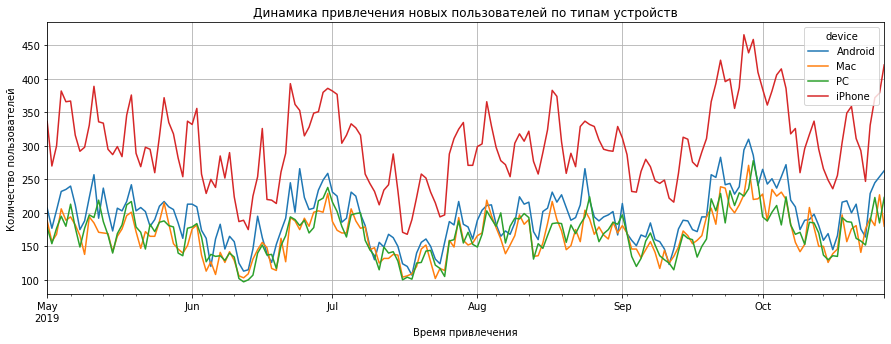

In [28]:
#строим график динамики привлечения пользователей разных устройств
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='device',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title("Динамика привлечения новых пользователей по типам устройств")
plt.xlabel("Время привлечения")
plt.ylabel("Количество пользователей")
plt.show()


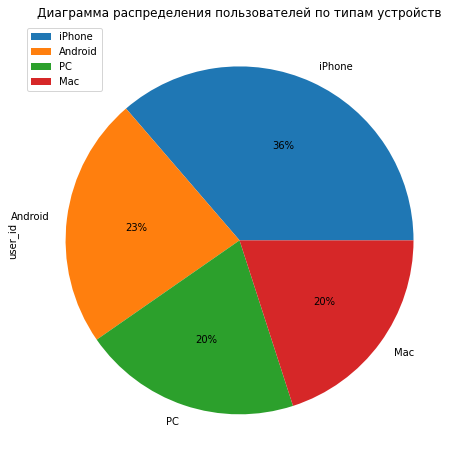

In [29]:
#строим круговую диаграмму для пользователей, привлеченных разных устройств
profiles.groupby('device').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False).plot(y = 'user_id', kind='pie', figsize =(8,8), autopct='%.0f%%')
plt.title("Диаграмма распределения пользователей по типам устройств")
plt.show()

Мы видим, что больше всего было привлечено пользователей iPhone, следом идут пользователи Android, PC и на последнем месте по количеству пользователей - Mac.

Теперь вычислим, какие устройства дают нам больше всего платящих пользователей. 

In [30]:
#считаем количество платящих пользователей для каждого устройства
profiles.groupby('device').agg({'payer':'sum'}).sort_values(by='payer', ascending = False)

payer
device        
iPhone    3382
Android   2050
Mac       1912
PC        1537

Большинство платящих пользователей предпочитают пользоваться iPhone, следом идут любители Android, пользователи Mac, которые по общему количеству уступают пользователям PC чаще оказываются плаятщими пользователями, чем пользователи PC. Но это ее не все - посмотрим, как дела обстоят с процентным соотношением.

In [31]:
#считаем долю платящих пользователей для каждого устройства
profiles.groupby('device').agg({'payer':'mean'}).sort_values(by='payer', ascending = False)

payer
device           
Mac      0.063644
iPhone   0.062079
Android  0.058518
PC       0.050468

Платящие пользователи Mac занимают самую большую долю от общего числа пользователей устройств. Самая низкая доля - у пользователей PC и Android. Второе место занимают пользователи iPhone.

## По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Действуем по проверенной схеме.

In [32]:
#считаем количество пользователей для каждого канала
profiles.groupby('channel').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False)

user_id
channel                    
organic               56439
FaceBoom              29144
TipTop                19561
OppleCreativeMedia     8605
LeapBob                8553
WahooNetBanner         8553
RocketSuperAds         4448
MediaTornado           4364
YRabbit                4312
AdNonSense             3880
lambdaMediaAds         2149

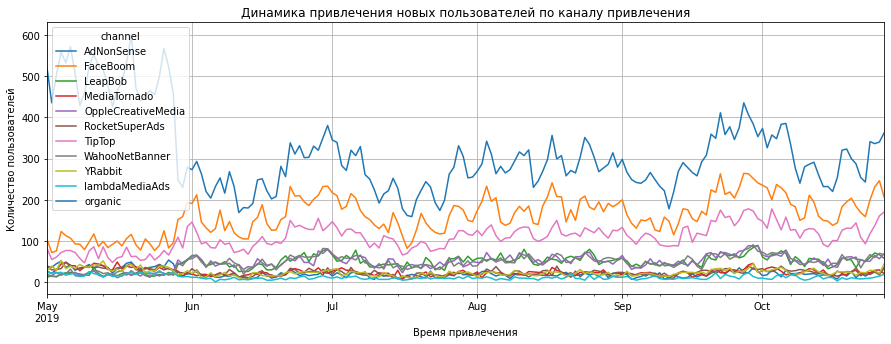

In [33]:
#строим график динамики привлечения пользователей из разных источников
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title("Динамика привлечения новых пользователей по каналу привлечения")
plt.xlabel("Время привлечения")
plt.ylabel("Количество пользователей")
plt.show()
plt.show()

Не совсем наглядно. Понятно только то, что первые три места по привлечению пользователей занимают каналы - organic, FaceBoom и TipTop. Построим график уже без этих каналов для наглядности.

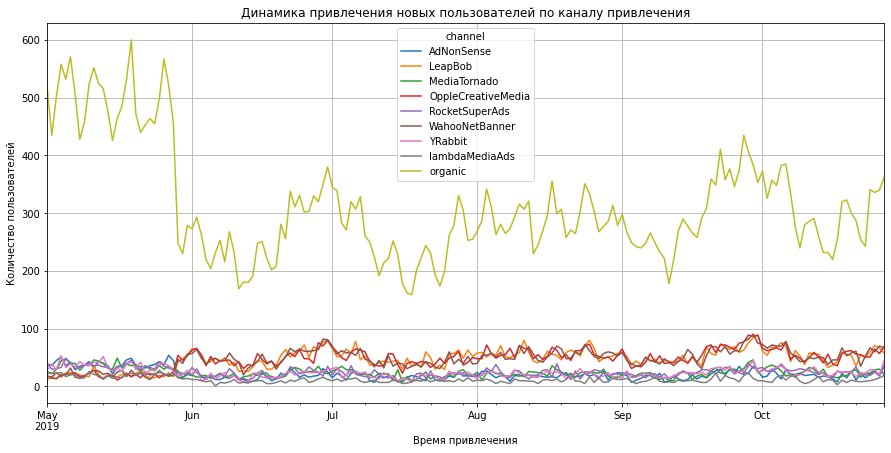

In [34]:
#строим график динамики привлечения пользователей из разных источников
profiles.query('channel != "FaceBoom" & channel != "TipTop"').pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
).plot(figsize=(15, 7), grid=True)
plt.title("Динамика привлечения новых пользователей по каналу привлечения")
plt.xlabel("Время привлечения")
plt.ylabel("Количество пользователей")
plt.show()
plt.show()

Мы видим, что на протяжении практически всего период довольно много в сравнении с оставшимися источниками привлекали такие, как OppleCreativeMedia, LeapBob и WahooNetBanner. Довольно немного привлекал источник lambdaMediaAds.

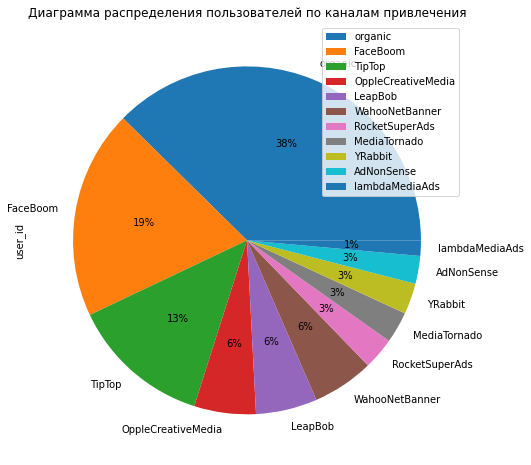

In [35]:
#строим круговую диаграмму для пользователей, привлеченных разных устройств
profiles.groupby('channel').agg({'user_id':'count'}).sort_values(by='user_id', ascending = False).plot(y = 'user_id', kind='pie', figsize =(8,8), autopct='%.0f%%')
plt.title("Диаграмма распределения пользователей по каналам привлечения")
plt.show()

Преобладающее большинство пользователей пришло из источника organic. Следом идут такие популярные источники как FaceBoom и TipTop. Последнее же место по количеству привлеченных пользователей занимает lambdaMediaAds.

In [36]:
#считаем количество платящих пользователей для каждого канала
profiles.groupby('channel').agg({'payer':'sum'}).sort_values(by='payer', ascending = False)

payer
channel                  
FaceBoom             3557
TipTop               1878
organic              1160
WahooNetBanner        453
AdNonSense            440
RocketSuperAds        352
LeapBob               262
OppleCreativeMedia    233
lambdaMediaAds        225
YRabbit               165
MediaTornado          156

По количеству платящих пользователей первое место занимает канал FaceBoom, за ним идут TipTop и organic. Первая тройка не изменилась - изменились лишь их места. Последнее место по количеству платящих пользовтелей занимает источник MediaTornado.

In [37]:
#считаем долю платящих пользователей для каждого канала
profiles.groupby('channel').agg({'payer':'mean'}).sort_values(by='payer', ascending = False)

payer
channel                     
FaceBoom            0.122049
AdNonSense          0.113402
lambdaMediaAds      0.104700
TipTop              0.096007
RocketSuperAds      0.079137
WahooNetBanner      0.052964
YRabbit             0.038265
MediaTornado        0.035747
LeapBob             0.030633
OppleCreativeMedia  0.027077
organic             0.020553

Интереснее дела обстоят с долями. Большое количество платящих пользователей обусловлено большим общим количеством привлеченных пользователей, что подтверждается данными. FaceBoom является источником, который по доле платящих пользователей занимает первое место среди всех остальных источников. За ним идет AdNonSense и, что удивительно, lambdaMediaAds, который по количеству пользователей занимает полследнее место, а по количеству платящих - предпредпоследнее. Самая же низкая доля платящих пользователей принадлежит кагорте пользователей, привлеченных из источника organic.	

## Вывод:
    

Больше всего пользователей из США, а меньше всего - из Германии.

Больше всего пользователей iPhone, а меньше всего - Mac.

Больше всего пользователей было привлечено из источника organic, а меньше всего - из lambdaMediaAds.

Говоря же о платящих пользователей, то:

**Больше всего платящих** пользователей было **из США**, при этом у пользователей этой страны **самая высокая доля платящих** пользователей. **Меньше всего платящих** пользователей было привлечено **из Германии**, но при этом по доле платящих пользователей страна занимает второе место, а **последнее - Франция**. Следовательно количество пользователей сказывается на количеств платящих пользователей.

**Больше всего платящих** пользователей было с устройствами **iPhone**, но при этом у пользователей этих устройств доля платящих пользователей **ниже, чем у Mac**, который имеет самую высокую долю платящих пользователей. **Меньше всего платящих** пользователей было привлечено с устройством **PC**. Доля платящих пользователей этого устройства самая низкая.


**Больше всего платящих** пользователей было привлечено из источника **FaceBoom**, который также имеет и **самую высокую долю** платящих пользователей. **Меньше всего платящих** пользователей было привлечено из источника **MediaTornado**, однако у него не самая низкая доля платящих пользователей. **Самая низкая доля платящих** пользователей принадлежит источнику **organic**.

# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

## Сколько денег потратили? Всего / на каждый источник / по времени

Информация о потраченных средствах находится в датасете costs. Выведем первые 5 строк данной таблицы, чтобы напомнить о том, как она выглядит.

In [38]:
#выведем на экран первые 5 строк таблицы
costs.head()

dt   channel  costs
0 2019-05-01  FaceBoom  113.3
1 2019-05-02  FaceBoom   78.1
2 2019-05-03  FaceBoom   85.8
3 2019-05-04  FaceBoom  136.4
4 2019-05-05  FaceBoom  122.1

### Общие затраты 

Сначала узнаем, сколько всего компания потратила средств на маркетинг.

In [39]:
#считаем общую сумму затраченных средств
round(costs['costs'].sum())

105497

Всего было затрачено около 105497 средств. Теперь посмотрим, как обстоят дела с разбивкой по источнику привлечения и времени привлечения.

### Затраты по источникам

In [40]:
#считаем сумму затраченных средств для каждого источника
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending = False)


costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Для наглядности результата построим круговую диаграмму

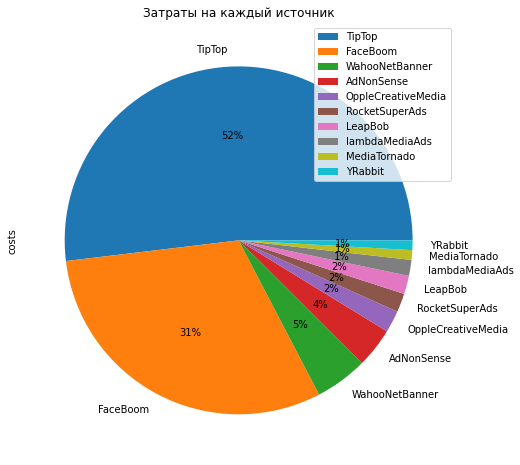

In [41]:
#строим круговую диаграмму
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending = False).plot(y = 'costs', kind='pie', figsize =(8,8), autopct='%.0f%%')
plt.title("Затраты на каждый источник")
plt.show()

Больше всего средств на привлечение пользователей было потрачено на такой источник как TipTop (более половины всех затраченных средств). На втором месте идет источник FaceBoom	(около 31% всех затраченных средств). Меньше всего же было потрачено на такие источники как YRabbit и MediaTornado (около 1%). Так же пользователи из источника organic привлекались бесплатно.

### Затраты во времени

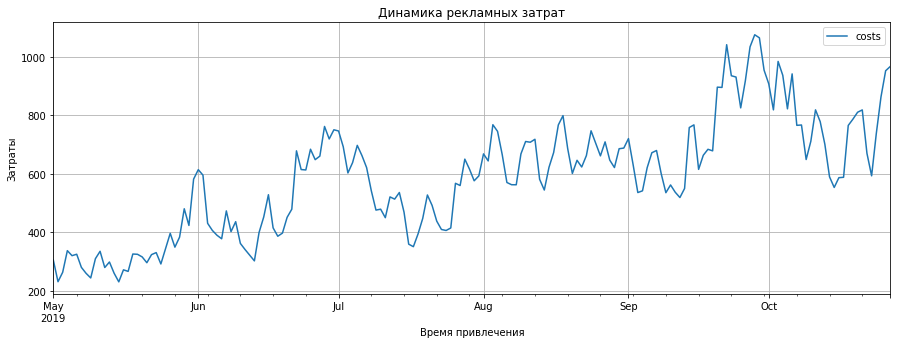

In [42]:
#строим график динамики привлечения пользователей из разных источников
costs.pivot_table(
    index='dt',  # источники переходов
    values='costs',  # ID пользователей
    aggfunc='sum',  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title("Динамика рекламных затрат")
plt.xlabel("Время привлечения")
plt.ylabel("Затраты")
plt.show()


Сделаем график динамики более приятным. Используем скользящее среднее.

In [43]:
#создаем отдельный датасет для работы со скользящим средним
cost2 = costs.pivot_table(
    index='dt',  # источники переходов
    values='costs',  # ID пользователей
    aggfunc='sum',  # подсчёт уникальных значений
)

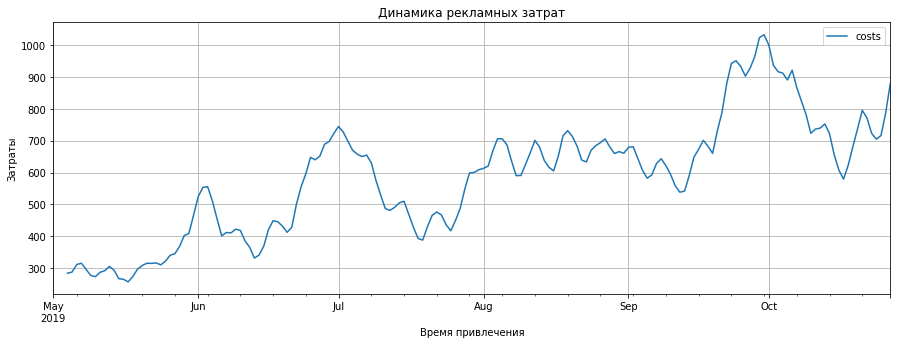

In [44]:
#создаем функцию для подсчета скользящего среднего
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df
#строим график по скользящему среднему
filter_data(cost2, 4).plot(figsize=(15, 5), grid=True)
plt.title("Динамика рекламных затрат")
plt.xlabel("Время привлечения")
plt.ylabel("Затраты")
plt.show()

Мы видим, что в целом расходы компании на маркетинг росли с каждым месяцем. Больше всего было потрачено в конце сентября - начале октября. Меньше всего было потрачено в мае-июне.

## Сколько в среднем стоило привлечение одного покупателя из каждого источника?

В датасете profiles есть специальный столбец `acquisition_cost`, который содержит стоимость привлечения каждого пользователя. Вспомним, как выглядит датасет.

In [45]:
#выводим первые 5 строк датасета
profiles.head()

user_id            first_ts         session_end  device     channel  \
0    599326 2019-05-07 20:58:57 2019-05-07 21:11:36     Mac    FaceBoom   
1   4919697 2019-07-09 12:46:07 2019-07-09 14:44:32  iPhone    FaceBoom   
2   6085896 2019-10-01 09:58:33 2019-10-01 12:30:18  iPhone     organic   
3  22593348 2019-08-22 21:35:48 2019-08-22 21:52:45      PC  AdNonSense   
4  31989216 2019-10-02 00:07:44 2019-10-02 00:20:52  iPhone     YRabbit   

          region         dt      month  payer  acquisition_cost  
0  United States 2019-05-07 2019-05-01   True          1.088172  
1  United States 2019-07-09 2019-07-01  False          1.107237  
2         France 2019-10-01 2019-10-01  False          0.000000  
3        Germany 2019-08-22 2019-08-01  False          0.988235  
4  United States 2019-10-02 2019-10-01  False          0.230769

Сначала рассчитаем среднюю стоимость привлечения одного пользователя вне зависимости от источника.

In [46]:
#рассчитываем среднюю стоимость привлечения одного пользователя
print(f'Средняя стоимость привлечения одного пользователя - {round(profiles["acquisition_cost"].mean(), 3)}')

Средняя стоимость привлечения одного пользователя - 0.703


Теперь же посмотрим, сколько обходятся пользователи из различных источников.

In [47]:
#рассчитываем среднюю стоимость привлечения одного пользователя для каждого из каналов
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending = False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

Самыми дорогими оказались пользователи, привлеченные из канала TipTop. Один пользователь из данного источника в среднем стоит в 4 раза дороже средней цены привлечения пользователя. Следом идут источники FaceBoom и AdNonSense. Самым же дешевым источником остается organic	, поскольку он бесплатный. Троица самых дешевых (небесплатных источников) - это LeapBob, MediaTornado и YRabbit

## Вывод:

Расходы компании на маркетинг с каждым месяцев растут. Самое затратное время года - осень, а самое менее затратное - весна.

Больше всего денег было потрачено на привлечение пользователей из канала TipTop (52%  всех потраченных средств). При этом пользователи, привлеченные из данного канала являются самыми дорогими (2.8 за одного пользователя).

На втором месте по затратам на привелечение пользователей идет канал FaceBoom (около 31% всех потраченных средств). Пользователи данного источника тоже дорогие -1,1 за одного привелченного пользователя, что незначительно выше средней траты на привлечение одного пользователя.

Источник organic совсем не требует вложений и привлекает пользователей бесплатно. Меньше всего было потрачено средств на такие источники как MediaTornado и YRabbit. Привлечение пользователей из данных источников является одним из самых дешевых - 0.21 за одного пользователя.

# Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируем общую окупаемость рекламы

Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

В качестве момента анализа возьмем указанную в условии дату - `1-го ноября 2019 года`. Горизонтом же анализа будут 14 дней, поскольку мы будем считать, что окупаемость должна наступать не позднее, чем через `2 недели` после привлечения пользователей. 

In [48]:
#момент анализа
observation_date = datetime(2019, 11, 1).date()
#горизонт анализа
horizon_days = 14

Чтобы получить общую LTV применим заготовленную функцию.

Прежде, чем приступить к работе, нужно избавиться от пользователей, привлеченных из источника - organic, поскольку за них мы не платим, и, соответсвенно, они не могут отражать окупаемость.

In [49]:
profiles = profiles.query('channel != "organic"')

In [50]:
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_raw, ltv_grouped, ltv_in_time,  roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days)

Дабы удобнее работать с графиками составим собственную функцию, которая будет получать данные о LTV И ROI, а выведет на экран все графики и тепловые карты по ним.

In [51]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ltv.T.plot(grid=True, figsize=(10, 5))
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
    #тепловая карта для LTV
    plt.figure(figsize=(15, 4))
    sns.heatmap(ltv, annot=True, fmt='.2f')
    plt.title('Тепловая карта LTV')
    plt.xlabel('Лайфтайм')
    plt.show()

    # второй график — динамика ltv
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, figsize=(10, 5))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    


    # третий график — динамика cac
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, figsize=(10, 5))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    roi.T.plot(grid=True, figsize=(10, 5))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    plt.ylim(0.2, 1.4)

    
    #тепловая карта для ROI
    plt.figure(figsize=(15, 4))
    sns.heatmap(roi, annot=True, fmt='.2f')
    plt.title('Тепловая карта ROI')
    plt.xlabel('Лайфтайм')
    plt.show()


    # пятый график — динамика roi

    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, figsize=(10, 5))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


<Figure size 1440x720 with 0 Axes>

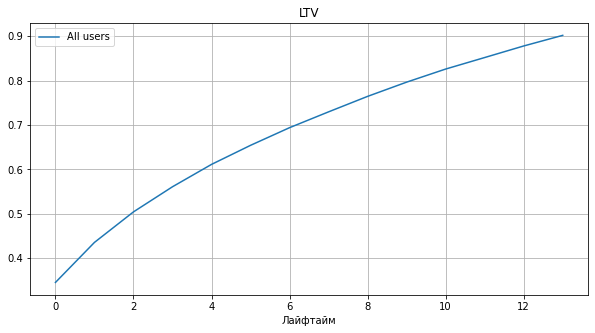

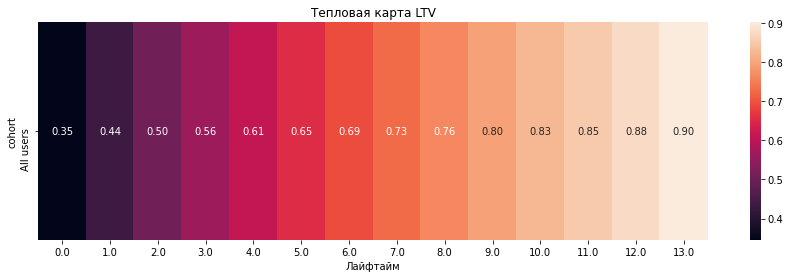

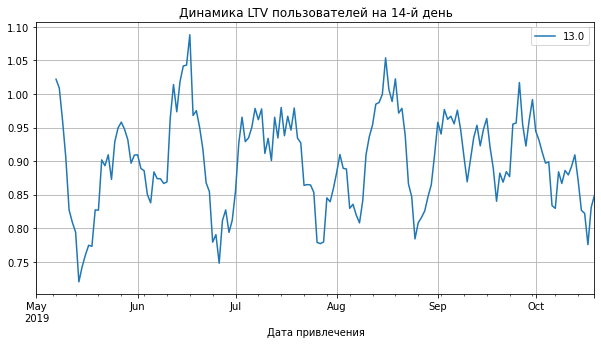

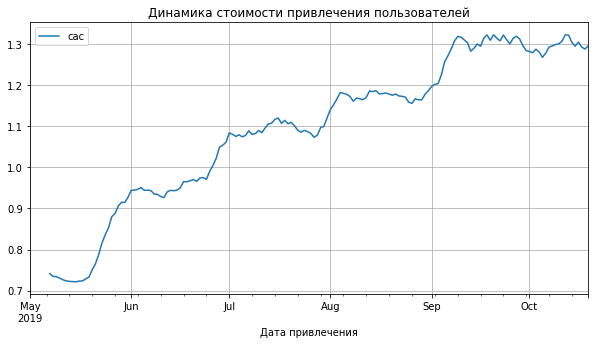

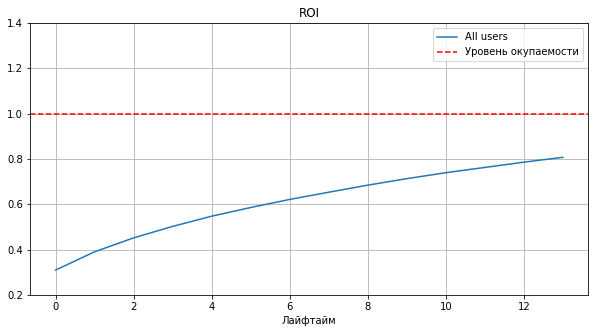

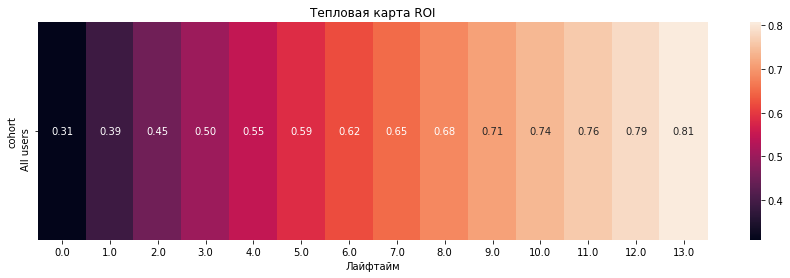

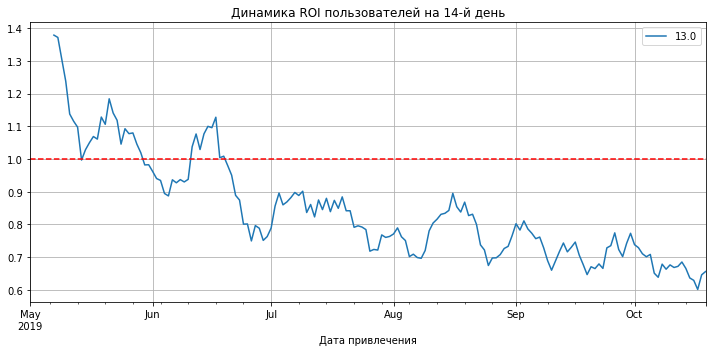

In [52]:
#применяем функцию
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Что мы видим?
1) LTV 14 дня «жизни» для всех пользователей приложения составит около 0.9 условных единиц. Это при том, что в среднем на привлечение одного пользователя тратится 0.703 условные единицы. Результаты не самые плохие.

2) Из тепловой карты мы видим, что LTV за дни жизни растет со средней скоростью.

3) Мы видим, что на раз в месяц встречаются период, в который были привлечены пользователи, когда LTV пользователей сначала резко возрастал, после чего резко падал. Пользователи же привлеченные в середние мая показали самый низкий LTV на 13 день. Примерно в середине месяца LTV достигал довольно высоких результатов. В целом можно сказать, что LTV подвержен сезонности. Динамика довольно неплохая и к осени становится более стабильной.

4) С мая по сентябрь произошел резкий скачок в затратах на рекламу. Расходы на рекламу выросли примерно в 2 раза, после чего стабилизировались.

5) Реклама не окупается. ROI в конце второй недели — около 81%. Это довольно странно, учитывая не самый низкий уровень LTV. Возмжно компания слишком много расходует средств на рекламу.

6) Реклама значительно окупалась только в период с мая по июнь (в последний раз - в середине июня). В конце июня она уже прекратила окупаться. При этом видна тенденция, снижения рентабельности инвестиций с каждым месяцем. Это объясняется тем, что рекламные расходы с каждым месяцев росли, в то время как доходы оставались нестабильны, при этом не часто превышая расходы.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

Посмотрим на те же самые показатели, но уже с разбивкой по устройствам.

In [53]:
#задаем разбивку
dimensions = ['device']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

<Figure size 1440x720 with 0 Axes>

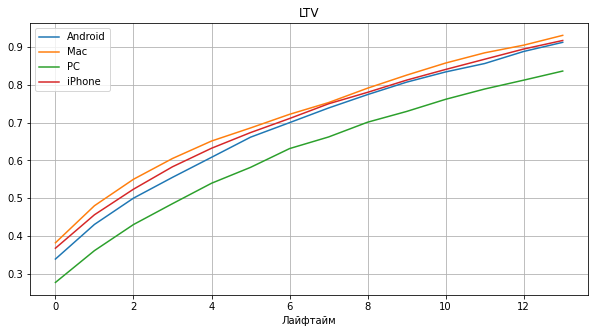

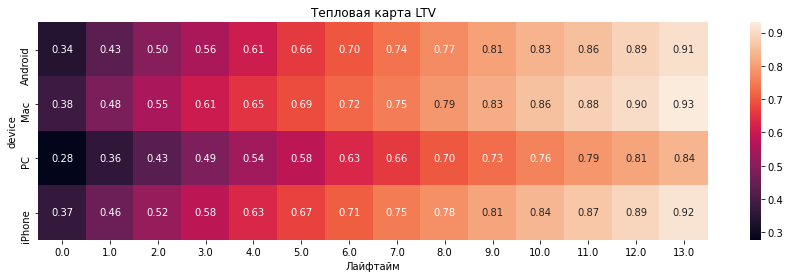

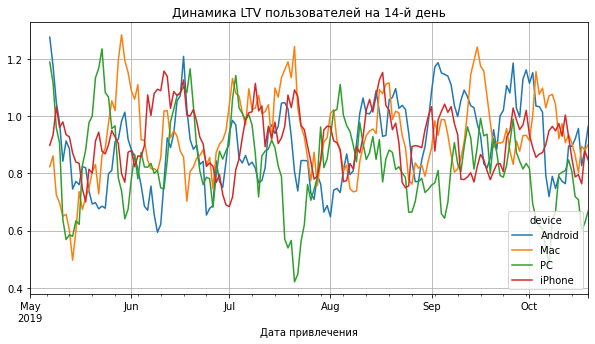

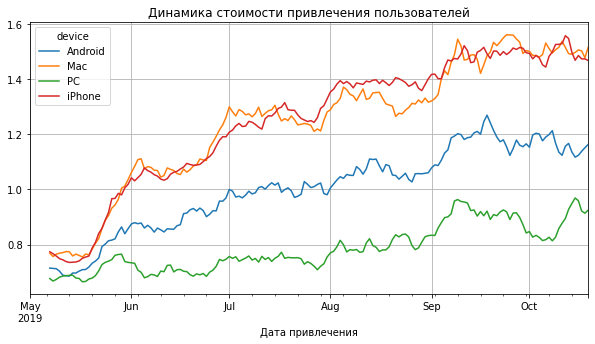

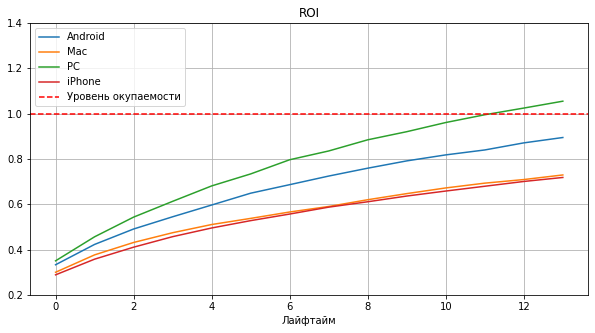

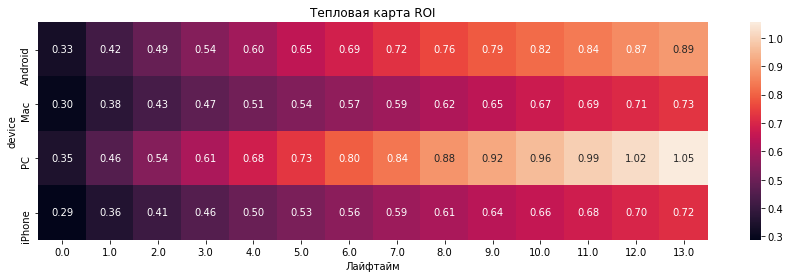

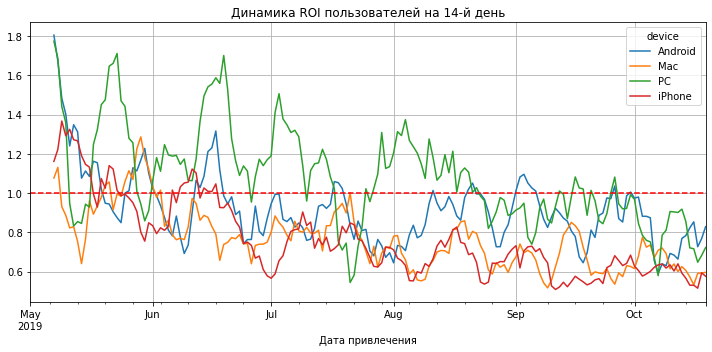

In [54]:
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Что мы видим?

1) Самый высокий LTV у пользователей Mac и iPhone. LTV пользователей Android находится с ними на одном уровне, но чуть ниже. LTV же пользователей PC заметно ниже, чем у всех остальных.

2) LTV пользователей Android на 14 день составляет 0.91 у.е, пользователей Mac - 0.93, пользователей PC - 0.84, пользователей же iPhone - 0.92. В принципе у всех устройств LTV находится на одном и том же уровне, за исключением PC - у него LTV заметно ниже.

3) По графику динамики видно, что LTV у всех устройств был примерно одинаков. Однако у PC, начиная с июля началось падение LTV. Возможно это связано с обновлением приложения, которое могло сопровождаться возникновением ошибок.


4) Расходы на рекламу среди пользователей Mac и iPhone были самыми высокими, в то время как релама среди пользователей Android была заметно ниже, а реклама среди пользователей PC была самой низкой. Также заметен рост рекламных расходов завесь период. Однако этот рост для PC был практически незаметен. Заметное увеличение расходов произошло только ближе к осени.

5) Реклама смогла окупиться только среди пользователей PC (на 13 день жизни пользователя). Пользователи остальных устройств не окупились. Пользователи Android были близки к тому, чтобы окупиться, но за 2 недели этого не сделали. Пользователи Mac и iPhone были далеки от окупаемости.

6) ROI на конец 2 недели для пользователей Android составляет 0.89, для пользователей Mac - 0.73, для пользователей PC - 1.05, для пользователей iPhone - 0.72. Это все при довольно схожем LTV. Объяснение преимущества по ROI у пользователей PC заключается в том, что пользователи данного устройства имели примерно одинаковый LTV с пользователями других устройств, но при этом расходы на их привлечение были намного ниже, чем стоило привлечение пользователей других устройств. Привлечение же пользователей iPhone и Mac было неоправданно дорогим.

7) До конца июня пользователи всех устройств окупались с перменным успехом. На фоне остальных выделялись пользователи PC, имеющие большую ROI. Однако впоследствии все пользователи, за исключением PC прекратили окупаться. У PC интересная динамика ROI, сходная с динамикой LTV. В целом в связи с падением в середине июля LTV пользователей PC и ростом расходов (хоть и незначительным) к осени и пользователи PC прекратили окупаться.

### Проанализируем окупаемость рекламы с разбивкой по странам

In [55]:
#задаем разбивку
dimensions = ['region']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_region, ltv_region, ltv_history_region,  roi_region, roi_history_region = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

<Figure size 1440x720 with 0 Axes>

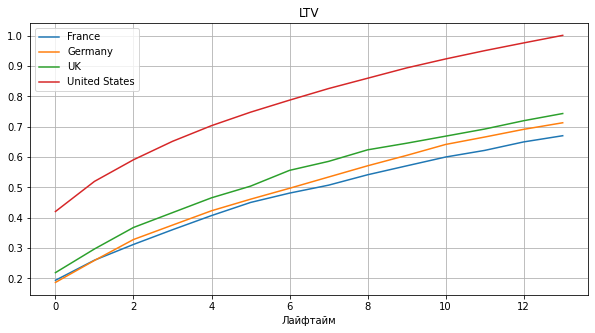

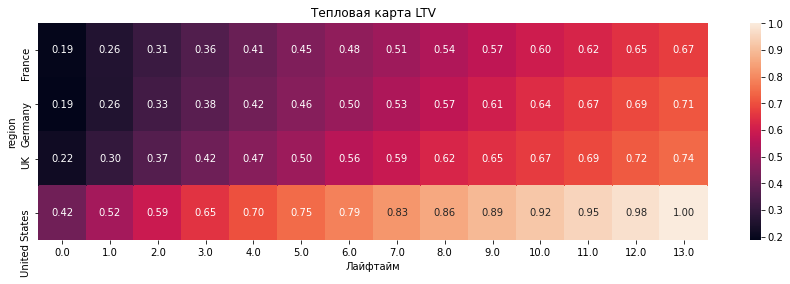

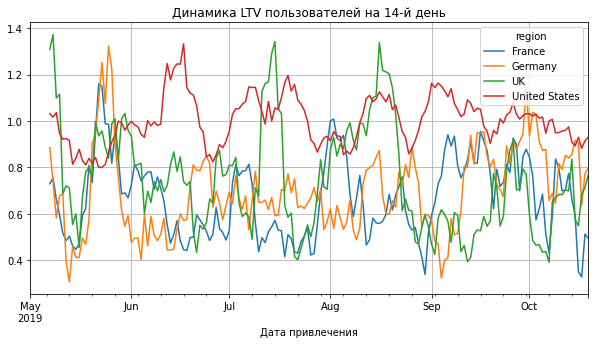

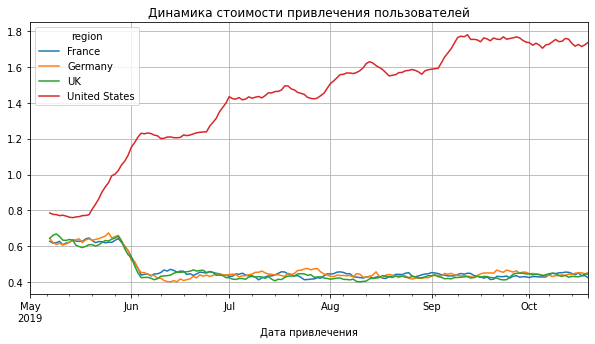

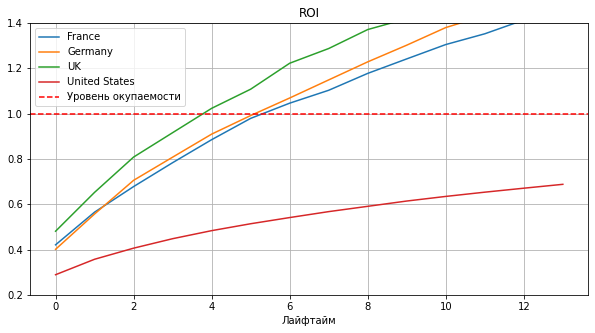

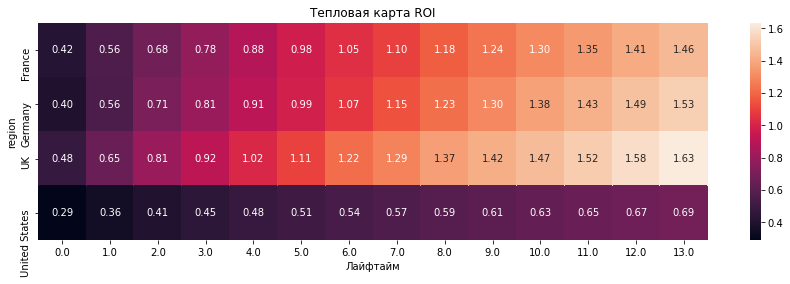

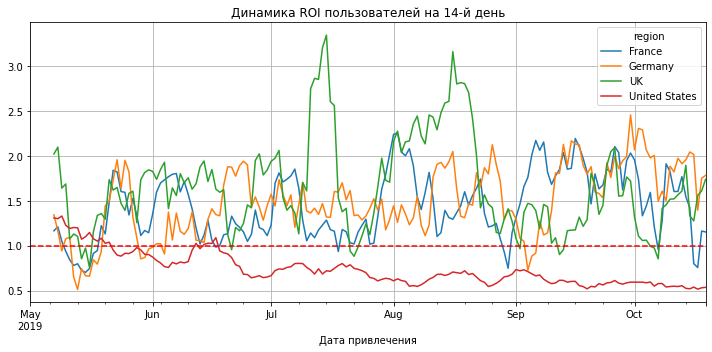

In [56]:
#применяем функцию
plot_ltv_roi(ltv_region, ltv_history_region,  roi_region, roi_history_region, horizon_days, window=7)

Что мы видим?

1) Самый большой LTV у пользователей из США. Пользователи из Великобритании и Германии имеют LTV заметно ниже, чем у США. Самый низкий LTV у Франции.

2) Средний LTV на 2 неделю у Франции составляет примерно 0.67 у Германии - 0.71, у Великобритании - 0.74, у США же - 1!

3) Пользователи из США имели более-менее стабильную и высокую динамику LTV, и заметного снижения у них незаметно. Пользователи из Франции имеют низкую LTV на протяжении всего периода, однако ближе к осени она начала увеличиваться. Пользователи Германии имели сходную LTV, как и во Франции, но в целом она была выше и пики были более заметны. Пользователи из Великобритании имеют довольно нестабильную динамику LTV, которая сопровождалась довльно заметными пиками и резкими падениями. Динамика подвержена сезонности.

4) Рекламные расходы в Германии, Франции и Великобритании находятся на одном уровне и довольно низки. Со временем они уменьшаются. Рекласные же расходы в США безумно велики. Примерно в 4-5 раз больше, чем в 3 других странах. И с каждым месяцем они растут.

5) Мы видим, что на 4 день жизни окупились пользователи из Великобритании (163% на 14 день), на 5 день жизни окупились пользователи из Германии (153% на 14 день) и Франции (246% на 14 день). Пользователи из США совсем не окупились (69% на 14 день).

6) Пользователи США, привлеченные до середины мая еще окупались, а вот после - вовсе нет. Пользователи Великобритании имели среднюю окупаемость, но летом она выросла в несколько раз, после чего вернулась на прежние уровни. Окупаемость Германии и Франции оставалась примерно на одном уровне и практически всегда была выше 100%.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

In [57]:
#задаем разбивку
dimensions = ['channel']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_channel, ltv_channel, ltv_history_channel,  roi_channel, roi_history_channel = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

<Figure size 1440x720 with 0 Axes>

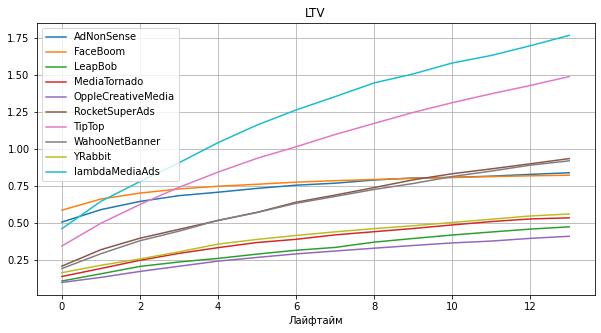

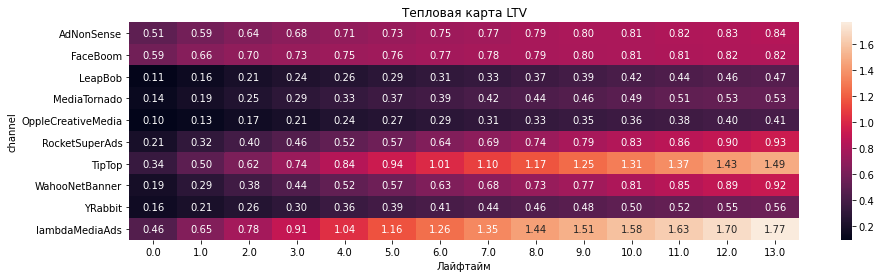

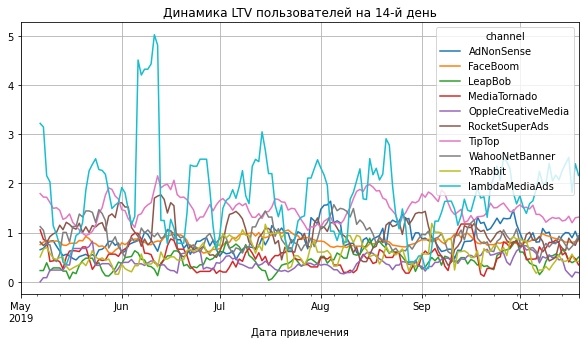

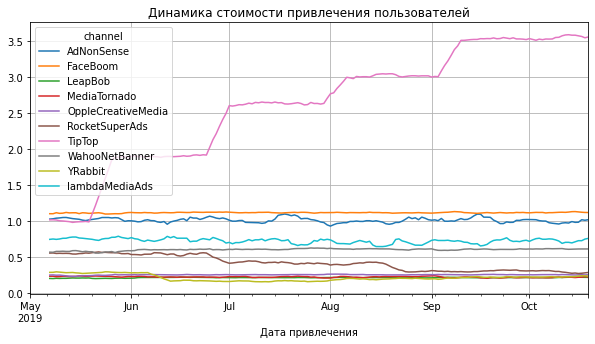

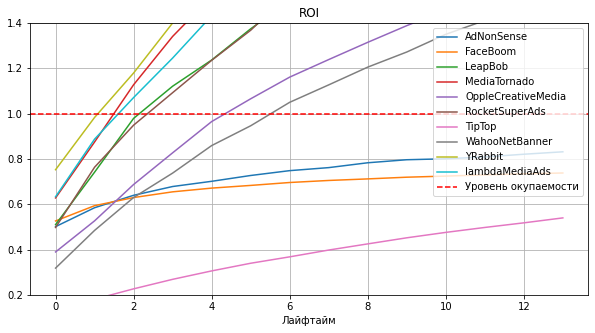

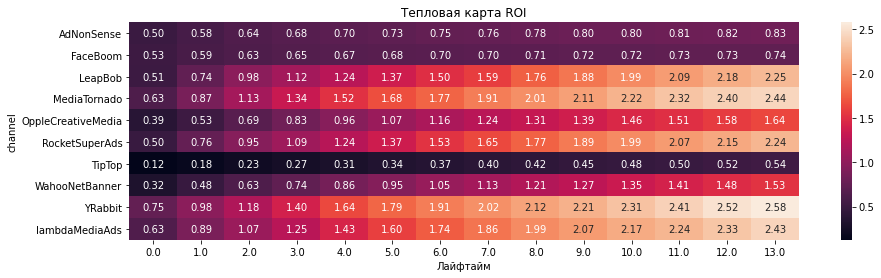

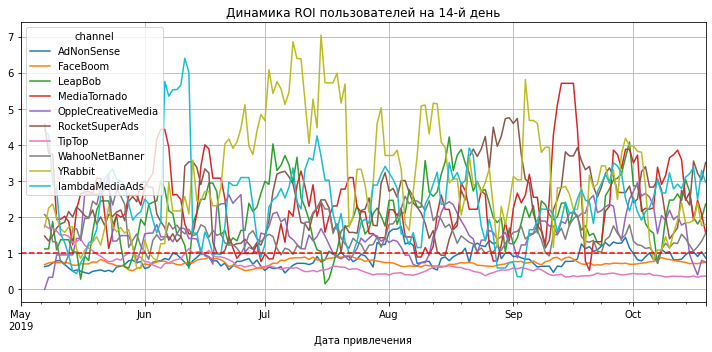

In [58]:
#применяем функцию
plot_ltv_roi(ltv_channel, ltv_history_channel,  roi_channel, roi_history_channel, horizon_days, window=7)

Дабы лучше увидить динамику, разобьем ее на два графика. Построим собственную функцию, которая выведет 2 графика - в одном будут каналы с высокой динамикой LTV, а в другом - с более низкой. Так же сделаем и с динамикой ROi.

In [59]:
#каналы с высокой динамикой LTV
ltv_history_channel1 = ltv_history_channel.query('channel == "AdNonSense" or channel == "lambdaMediaAds" or channel == "RocketSuperAds" or channel == "TipTop" or channel == "WahooNetBanner"')
#каналы с низкой динамикой LTV
ltv_history_channel2 = ltv_history_channel.query('channel != "AdNonSense" & channel != "lambdaMediaAds" & channel != "RocketSuperAds" & channel != "TipTop" & channel != "WahooNetBanner"')
#каналы с низкой динамикой ROI
roi_history1 = roi_history_channel.query('channel != "YRabbit" & channel != "MediaTornado" & channel != "lambdaMediaAds" & channel != "RocketSuperAds" & channel != "WahooNetBanner"')
#каналы с низкой высокой ROI
roi_history2 = roi_history_channel.query('channel == "YRabbit" or channel == "MediaTornado" or channel == "lambdaMediaAds" or channel == "RocketSuperAds" or channel == "WahooNetBanner"')

In [60]:
def plot_ltv_roi2(ltv_history1, ltv_history2, roi_history1, roi_history2, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))
    
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history1 = roi_history1.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

      # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history2 = roi_history2.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history1 = ltv_history1.drop(columns=['cohort_size'])[[horizon - 1]]

     # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history2 = ltv_history2.drop(columns=['cohort_size'])[[horizon - 1]]
    
   

    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history1.index.names if name not in ['dt']]
    filtered_data1 = ltv_history1.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data1, window).plot(grid=True, figsize=(10, 5))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))


    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history2.index.names if name not in ['dt']]
    filtered_data2 = ltv_history2.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data2, window).plot(grid=True, figsize=(10, 5))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    
      # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history1.index.names if name not in ['dt']]
    filtered_data1 = roi_history1.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data1, window).plot(grid=True, figsize=(10, 5))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history2.index.names if name not in ['dt']]
    filtered_data2 = roi_history2.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data2, window).plot(grid=True, figsize=(10, 5))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))


   
    plt.tight_layout()
    plt.show() 

<Figure size 1440x720 with 0 Axes>

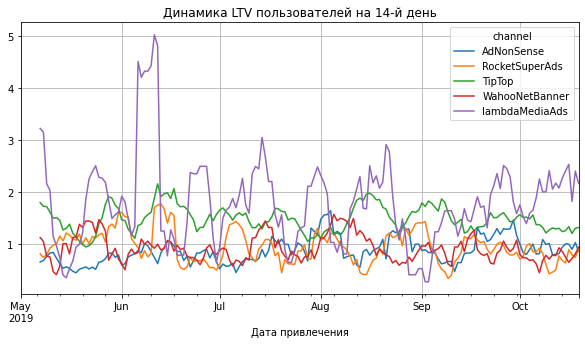

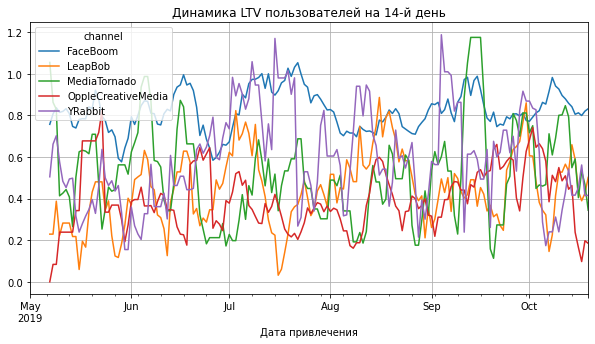

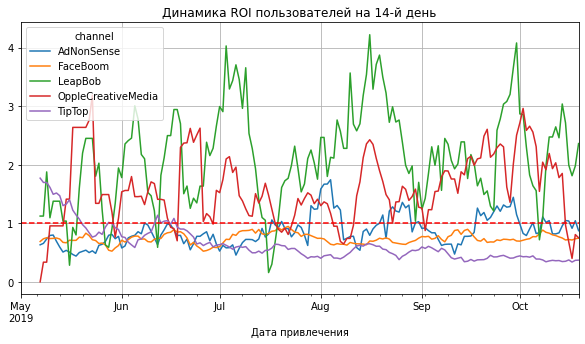

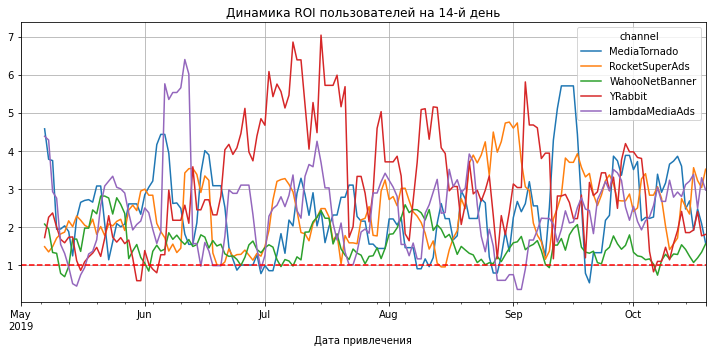

In [61]:
#применяем функцию
plot_ltv_roi2(ltv_history_channel1, ltv_history_channel2, roi_history1, roi_history2, horizon_days, window=7)

Теперь можно делать выводы

Что мы видим?

1) Самый большой LTV имели пользователи привлеченные с помощью источника lambdaMediaAds (1.77 на конец 2 недели), за ним идут пользователи, привлеченные из TipTop (1.49 на конец 2 недели). Самый низкий LTV у источников: OppleCreativeMedia (0.41 на конец 2 недели) и LeapBob(0.47 на конец 2 недели).

2) Динамика LTV подвержена сезонности, но тенденция в целом остается неизменной. lambdaMediaAds имел превосходство на протяжении всего периода, и динамика канала в целом осталась неизменной. Следом идет TipTop со стабильной динамикой, менее подверженной сезонности. Самая слабая динамика у OppleCreativeMedia и LeapBob - они подвержены одинаковым тенденциям, просто у одного источника кое-где пики повыше.

3) Крайне дорогим источником является TipTop, следом идет FaceBoom и AdNonSense. Самыми же дешевыми  LeapBob, MediaTornado и YRabbit. При этом рекламные расходы на все источники, кроме TipTop практически не менялась.

4) Не окупились только 3 источника - TipTop (к концу 2 недели - 54%), FaceBoom (к концу 2 недели - 74%) и AdNonSense (к концу 2 недели - 83%). Самые дорогие источники не окупились. Все остальные источники окупились.

5) Самыми же выгодными источниками оказались: YRabbit, MediaTornado, lambdaMediaAds, LeapBob и RocketSuperAds. На протяжении рассматриваемого пеСамое, что интересное -  эти источники являются самыми дешевыми по стоимости привлечения одного клиента. lambdaMediaAds же стал одним из самых окупаемых по причине очень высокого LTV и не самых больших затратах.

6) Динамика ROI говорит нам о том, что три самых неокупаемых источника таковыми являлись практически всегда. Все же остальные источники стабильно окупались, оставаясь подверженными сезонным изменениям.

###  Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Создадим функции для визуализации конверсии и удержания пользователей.

In [62]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [63]:
def plot_retention(retention, retention_history, horizon, window=3):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Сначала посчитаем общие конверсию и удержание.

In [64]:
#получаем таблицы конверсии
conversion_raw, conversion, conversion_history =  get_conversion(profiles, orders, observation_date, horizon_days)

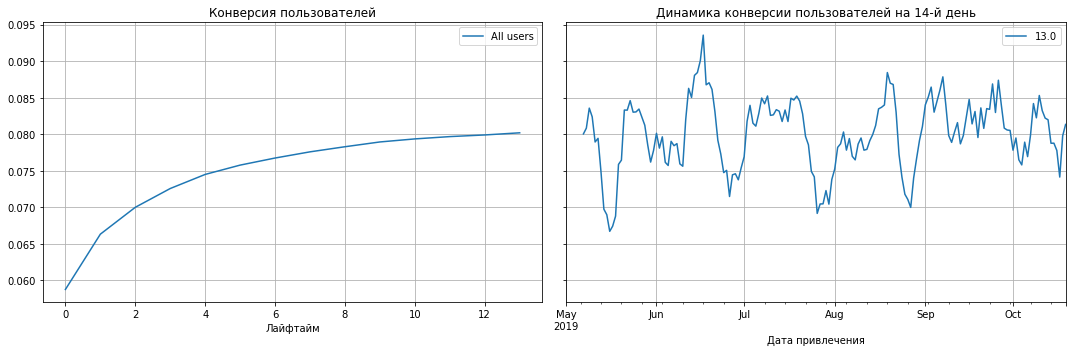

In [65]:
#визуализируем конверсию
plot_conversion(conversion, conversion_history, horizon_days)

Мы видим, что:

* Коэффициент конверсии не снижается. 

* Конверсия не превышает 100%. 

Следовательно, функция работает исправно.

In [66]:
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles, visits, observation_date, horizon_days)

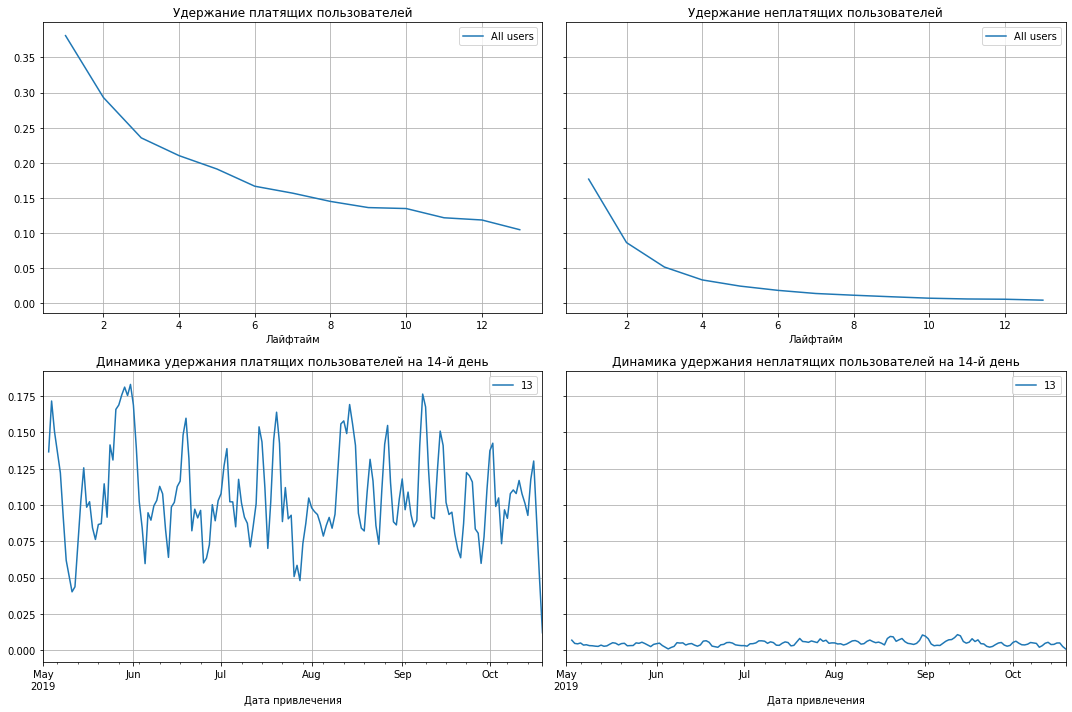

In [67]:
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Мы видим, что:

* Удержание убывает по экспоненциальному закону.

* Удержание неплатящих убывает быстрее, чем удержание платящих.

Следовательно, функция работает исправно.

#### Конверсия и удержание по типам устройств

Теперь рассмотрим эти метрики с разбивкой на **`типы устройств`**:

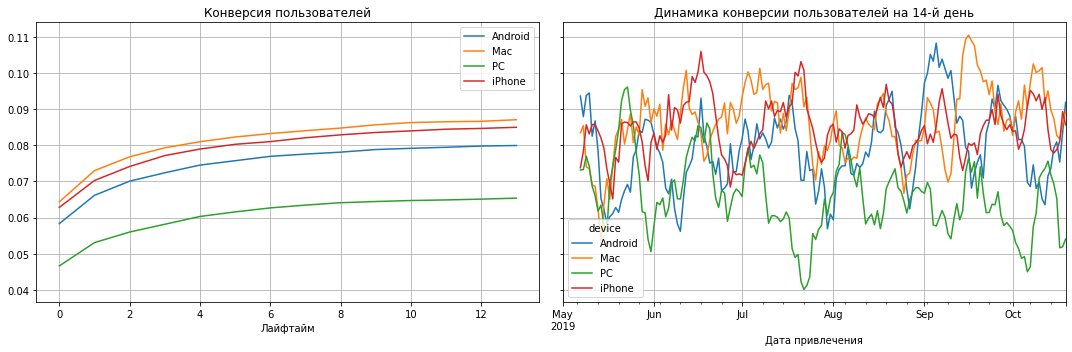

In [68]:
#задаем разбивку
dimensions = ['device']
#получаем таблицы конверсии
conversion_raw, conversion, conversion_history =  get_conversion(profiles, orders, observation_date, horizon_days, dimensions)
#визуализируем конверсию
plot_conversion(conversion, conversion_history, horizon_days)

Что мы видим?

1) Самая высокая конверсия у пользователей Mac. Пользователи Mac практически всегда конвертируются лучше остальных пользователей. Практически не уступая пользователям Mac, идут пользователи iPhone, которые так же очень хорошо конвертируются Это удивительно, поскольку с таким высоким уровнем конверсии пользователи данных устройств вовсе не окупаются.

2) Конверсия пользователей Android заметно ниже конверсии устройств Apple, но в целом остается относительно высокой. Несмотря на то, что конверсия этих пользователей ниже, чем у Mac и iPhone, они окупились лучше в отличии от последних.

3) Конверсия пользователей PC самая низкая и остается на такой на протяжении всего рассматриваемого периода. Однако они являются самыми окупаемыми. Также видно резкое падение в середине июля, что было характерно для LTV и ROI.

Низкая окупаемость с высокой конверсией может объясняться проблемами с удержанием пользователей. Посмотрим на удержание.

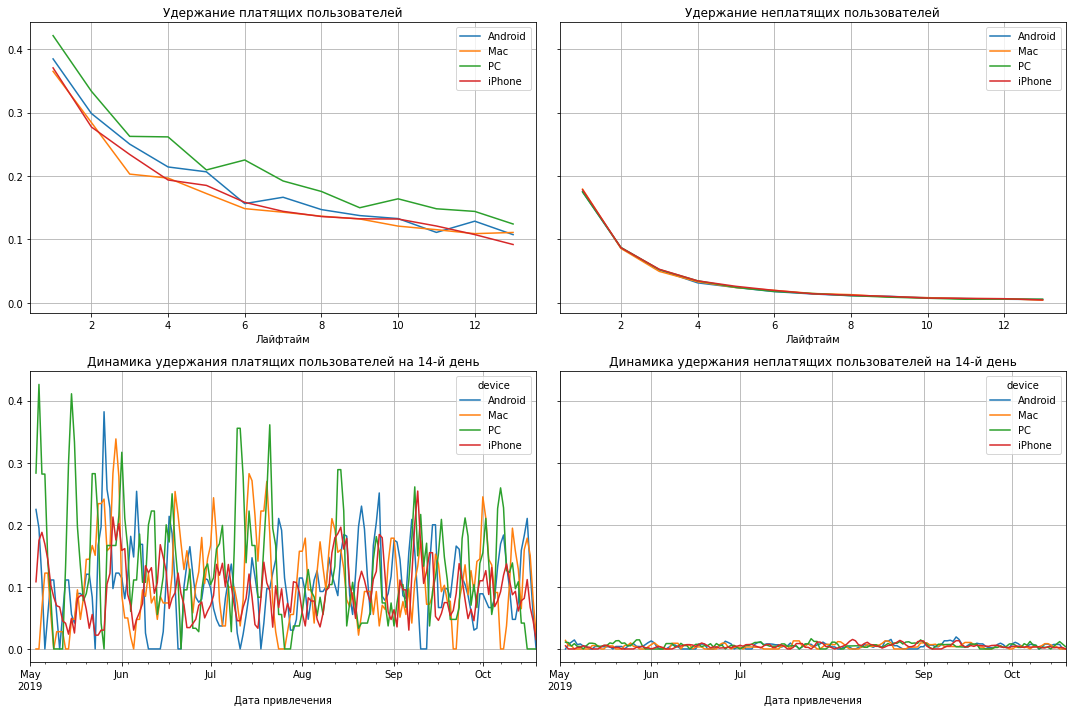

In [69]:
#задаем разбивку
dimensions = ['device']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles, visits, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Что мы видим?

1) Несмотря на высокую конверсию, пользователи Mac и iPhone плохо удерживаются. Пользователи Android по этому показателю выигрывают, но не намного.

2) Пользователи PC удерживаются заметно лучше, чем другие пользователи. Однако после августа удержание пользователей PC стало заметно снизилось, что может объясняться обновлением. В июля заметен рост удержания, после чего к концу августа произошл резкое падение. Видимо, этим и объясняются обвалы в других показателях в данный период.



#### Конверсия и удержание по регионам

Теперь рассмотрим эти метрики с разбивкой на **`регионы`**:

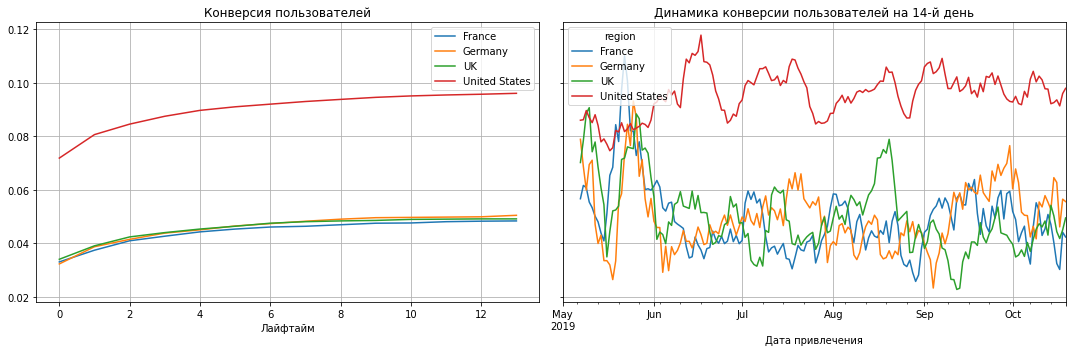

In [70]:
#задаем разбивку
dimensions = ['region']
#получаем таблицы конверсии
conversion_raw, conversion, conversion_history =  get_conversion(profiles, orders, observation_date, horizon_days, dimensions)
#визуализируем конверсию
plot_conversion(conversion, conversion_history, horizon_days)

Что мы видим?

1) Пользователи из США конвертируются намного лучше других пользователей. Высокая конверсия для этих пользователей стабильна.

2) Пользователи других стран заметно хуже конвертируются, чем пользователи из США. Их конверсия находится примерно на одном уровне.

Мы же помним, что пользователи из США оказались кране не окупаемы. Высокая конверсия и низкая окупаемость на лицо.
Это может быть так же связано с проблемами в удержании.

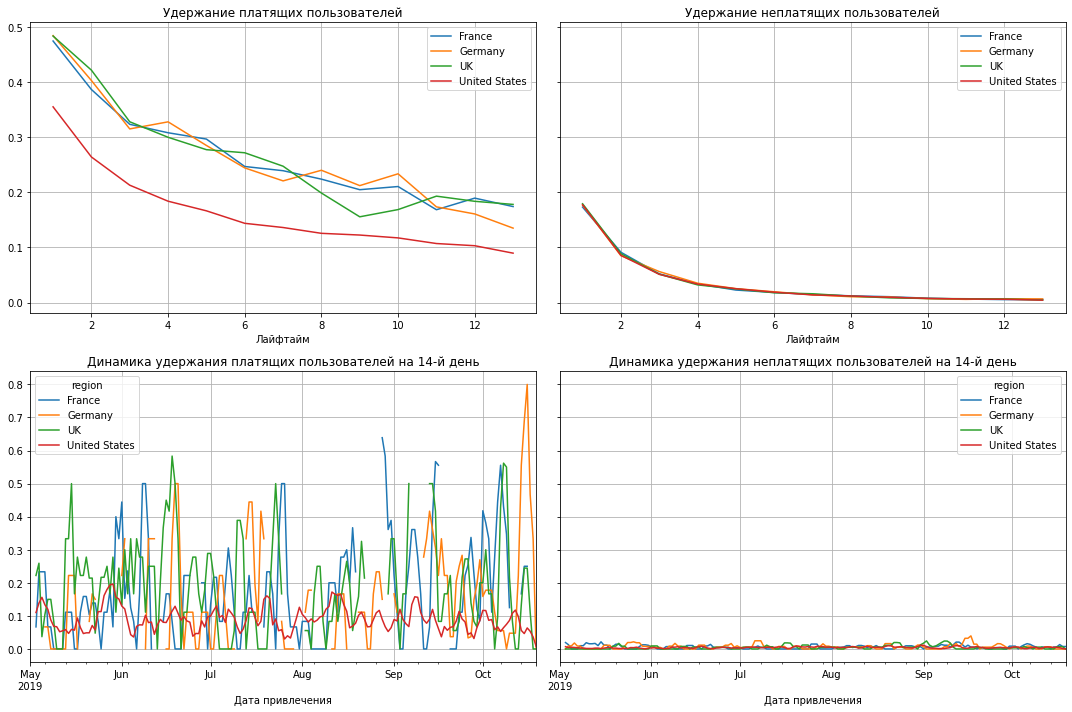

In [71]:
#задаем разбивку
dimensions = ['region']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles, visits, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Что мы видим?

1) Пользователи из США имеют крайне плохое удержание и на протяжении всего периода имет низкий уровень удержания.

2) Пользователи других стран имеют примерно одинаковый уровень удержания.

Возможа ли связь между проблемами с удержанием у пользователей из США и пользователей Mac, Android и iPhone?
Сейчас мы это и проверим. Посчитаем количество пользователей каждого типа устройств для каждой страны.

In [72]:
#считаем количество посетителей для каждой страны
profiles.groupby(['region', 'device']).agg({'user_id':'count'}).sort_values(by=['device', 'user_id'], ascending = False)

user_id
region        device          
United States iPhone     27548
UK            iPhone      2274
France        iPhone      2198
Germany       iPhone      1862
United States PC          6421
UK            PC          4551
France        PC          4384
Germany       PC          3797
United States Mac        15424
France        Mac         1163
UK            Mac         1086
Germany       Mac         1020
United States Android    12436
France        Android     3313
UK            Android     3243
Germany       Android     2849

Мы видим, что в США наибольшее количество пользователей iPhone, Android и Mac. Посмотрим, какой критерий подвергся сбоям - регион США или тип устройства - Android, Mac и iPhone.

Уберем из расчета удержания пользователей устройств всех пользователей из США и посмотрим на удержание.

In [73]:
#убираем пользователей из США
profiles2 = profiles.query('region != "United States"')
visits2 = visits.query('region != "United States"')

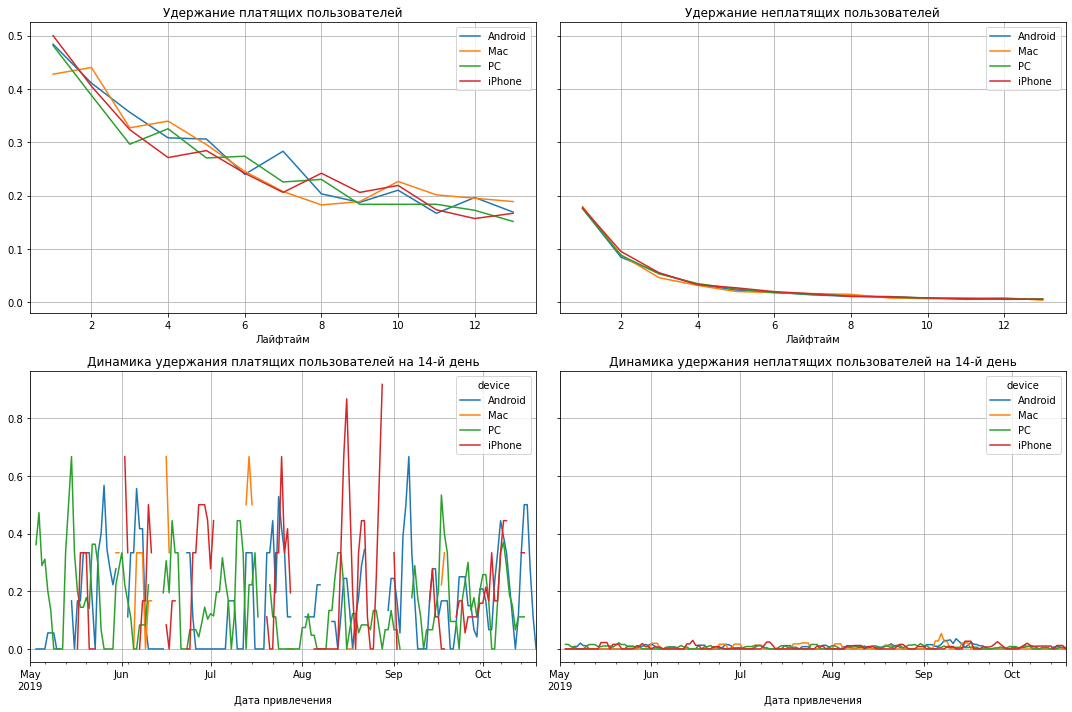

In [74]:
#задаем разбивку
dimensions = ['device']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles2, visits2, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Теперь удержание пользователей находится примерно на одном уровне и степень их снижения сейчас ниже.

Теперь допустим, что проблемы в типе устройства.

In [75]:
#убираем пользователей айфона и макбука
profiles3 = profiles.query('device != "iPhone" and device != "Mac"')
visits3 = visits.query('device != "iPhone" and device != "Mac"')

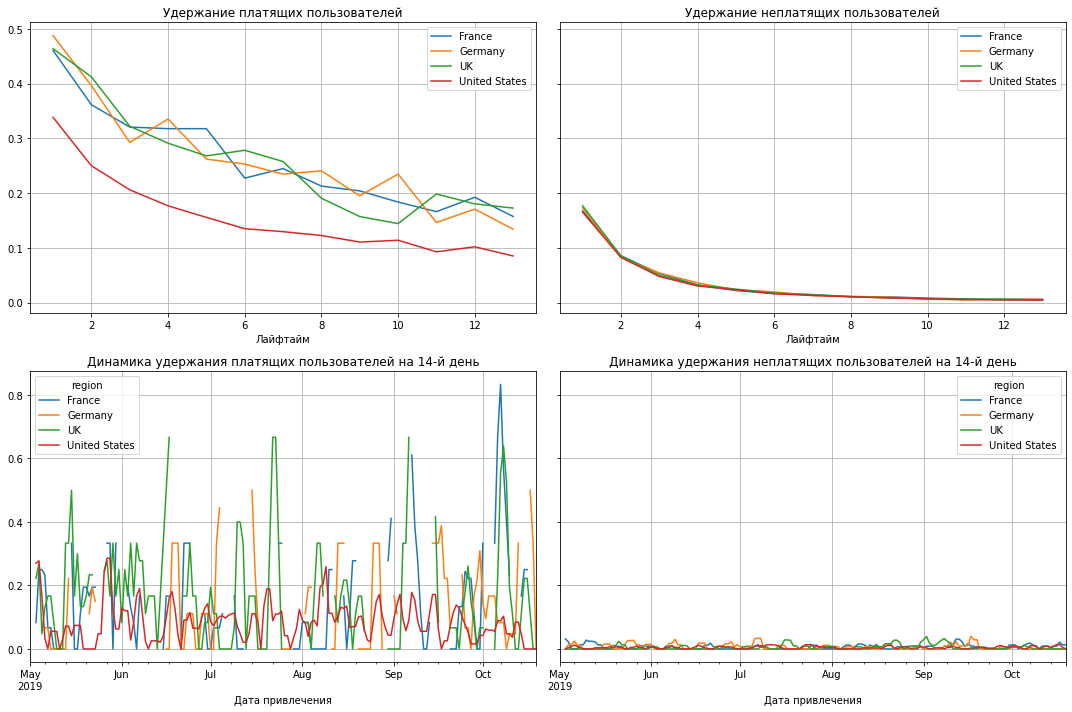

In [76]:
#задаем разбивку
dimensions = ['region']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles3, visits3, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Результат остался прежним. Удержание пользователей из США оказалось довольно низким. Следовательно, можно сделать предположение о том, что в США имеются проблемы с приложением, которые препятствуют удерживавать пользователей. Поскольку в США сконсолидирована огромная часть пользователей iPhone и Mac, то их удержание тоже падает за счет падения удержания пользователей США. Проверим наше предположение, убрав пользователей США из оценки окупаемости.

<Figure size 1440x720 with 0 Axes>

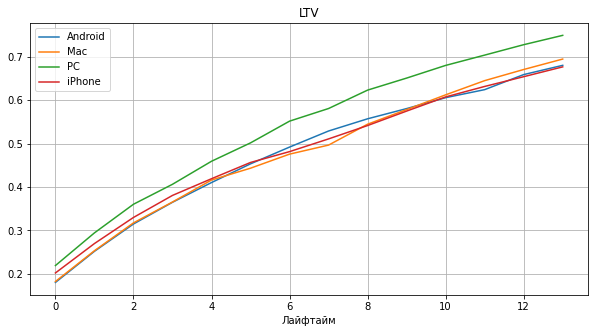

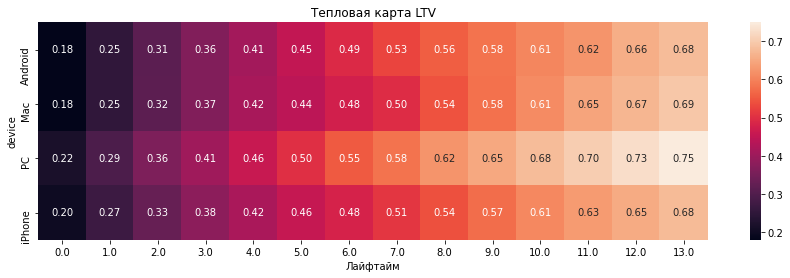

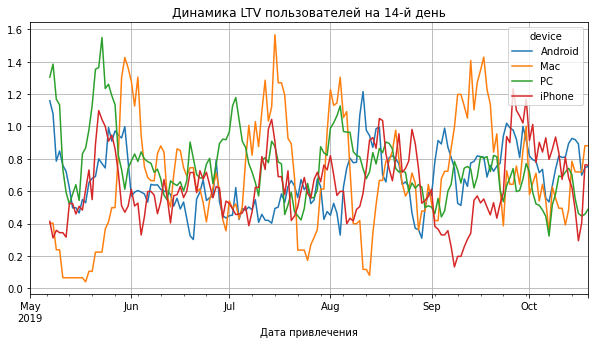

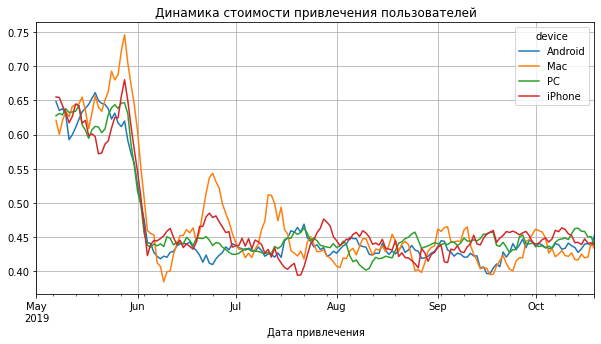

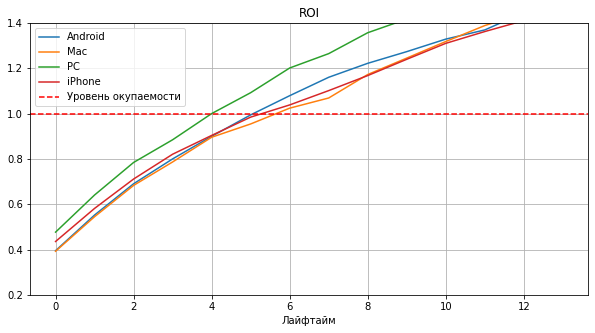

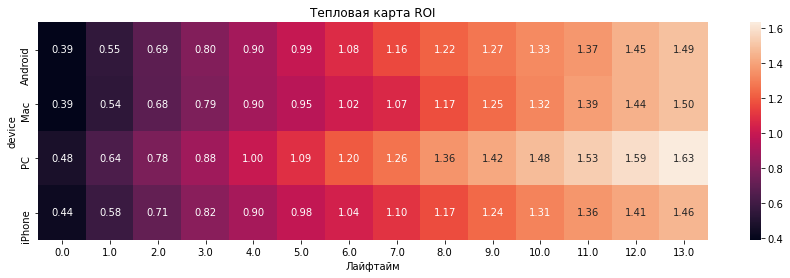

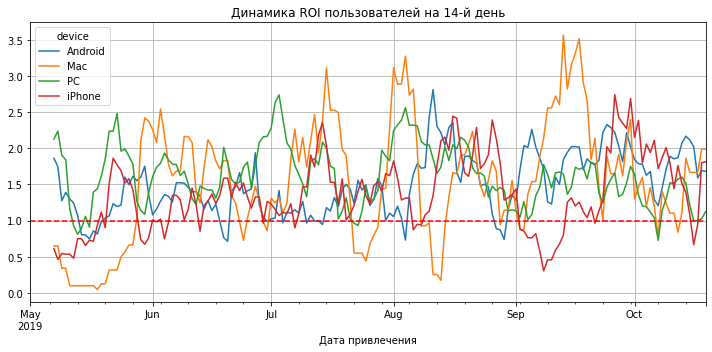

In [77]:
#задаем разбивку
dimensions = ['device']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles2, orders, observation_date, horizon_days, dimensions)
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Итог на лицо - пользователи всех устройств окупились примерно в одинаковые даты. Однако рано делать выводы. Мы смогли понять, что дело не в типе устройства. Проблемы связаны с США, однако дело может быть в канале привлечения.

#### Конверсия и удержание по источникам привлечения

Теперь рассмотрим эти метрики с разбивкой на **`источники привлечения`**:

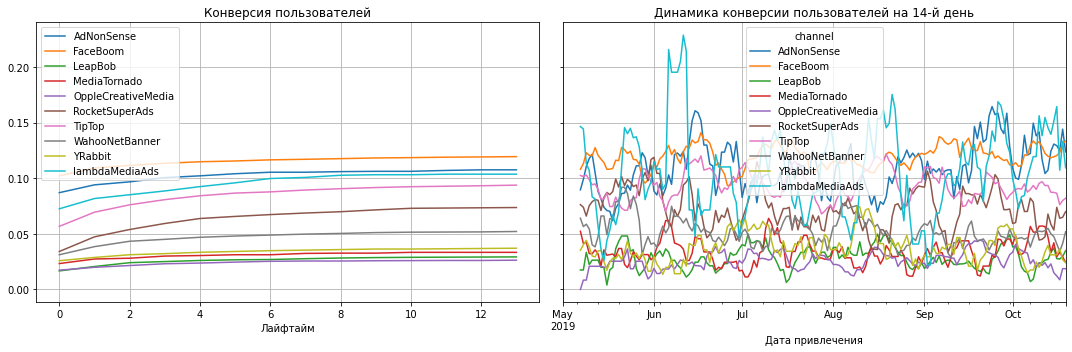

In [78]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы конверсии
conversion_raw, conversion, conversion_history =  get_conversion(profiles, orders, observation_date, horizon_days, dimensions)
#визуализируем конверсию
plot_conversion(conversion, conversion_history, horizon_days)

Для большей детальности разделим графики на кагорты с высокой и низкой конверсией.

In [79]:
#высокая конверсия
profiles_с1 = profiles.query('channel =="FaceBoom" or channel =="lambdaMediaAds" or channel == "AdNonSense" or channel =="TipTop"')
#низкая конверсия
profiles_с2 = profiles.query('channel !="AdNonSense" & channel !="FaceBoom" & channel !="lambdaMediaAds" & channel !="TipTop"')

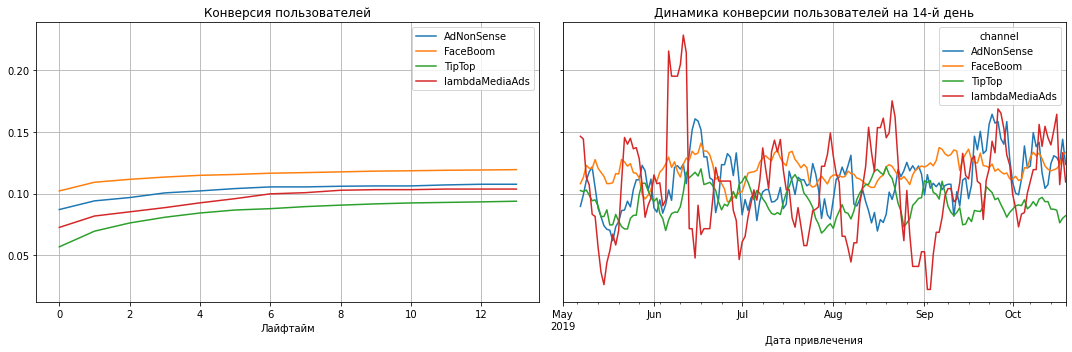

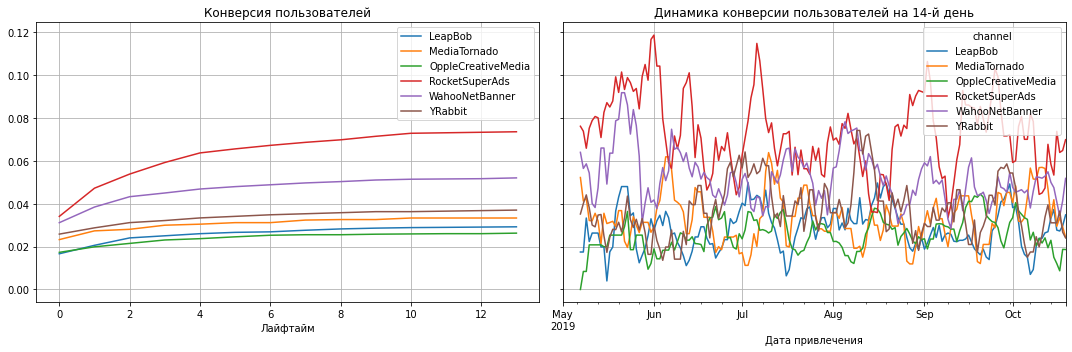

In [80]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы конверсии для низкой конверсии
conversion_raw1, conversion1, conversion_history1 =  get_conversion(profiles_с1, orders, observation_date, horizon_days, dimensions)
#визуализируем конверсию
plot_conversion(conversion1, conversion_history1, horizon_days)
#получаем таблицы конверсии для высокой конверсии
conversion_raw2, conversion2, conversion_history2 =  get_conversion(profiles_с2, orders, observation_date, horizon_days, dimensions)
#визуализируем конверсию
plot_conversion(conversion2, conversion_history2, horizon_days)

Что мы видим?

1) Самая высокая конверсия у пользователей, привлеченных из FaceBoom, но мы помним, что они не окупились. Возможно дело так же в удержании. Конверсия является самой высокой по причине того, что ее динамика стабильная. Динамика lambdaMediaAds выглядит выше, но у нее много сильных спадов есть.

2) Следом идут такие источники как AdnonSense, lambdaMediaAds и TipTop. Хочется заметить, что рекламные расходы на TipTop являются самыми высокими, а конверсия их уступает источникам, привлекающих пользователей за много меньшую цену. 

3) Самая низкая конверсия у каналов OppleSuperAds и LeapBob. Их динамика стабильна.

Посмотрим на удержание.

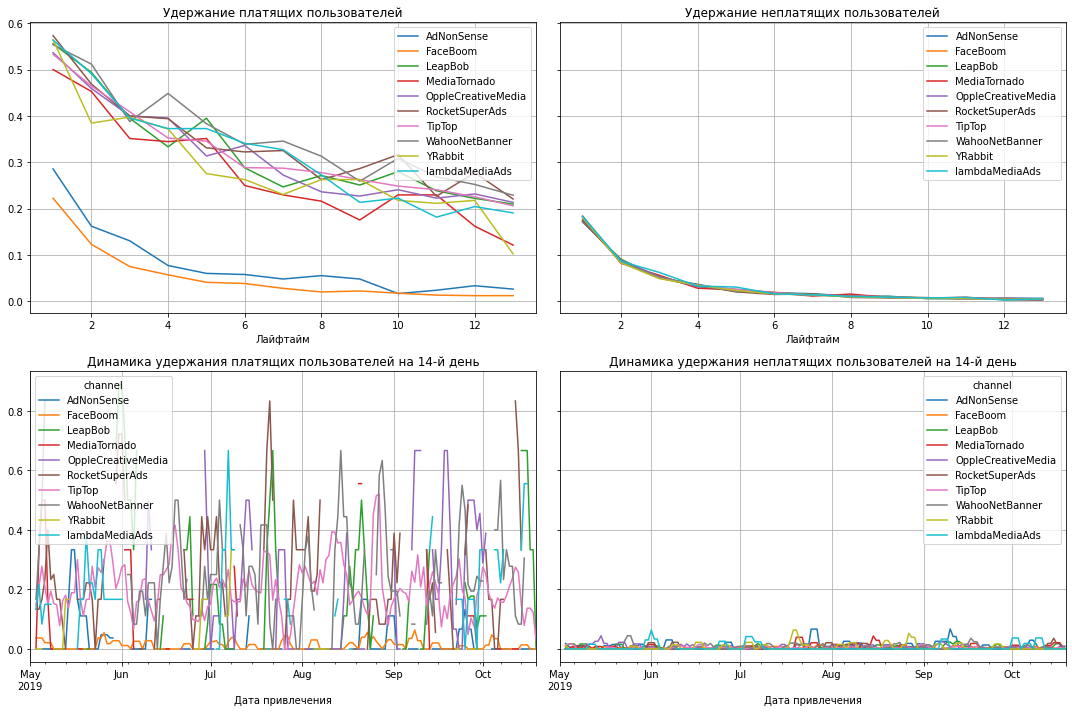

In [81]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles, visits, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Также разобьем на 2 кагорты.

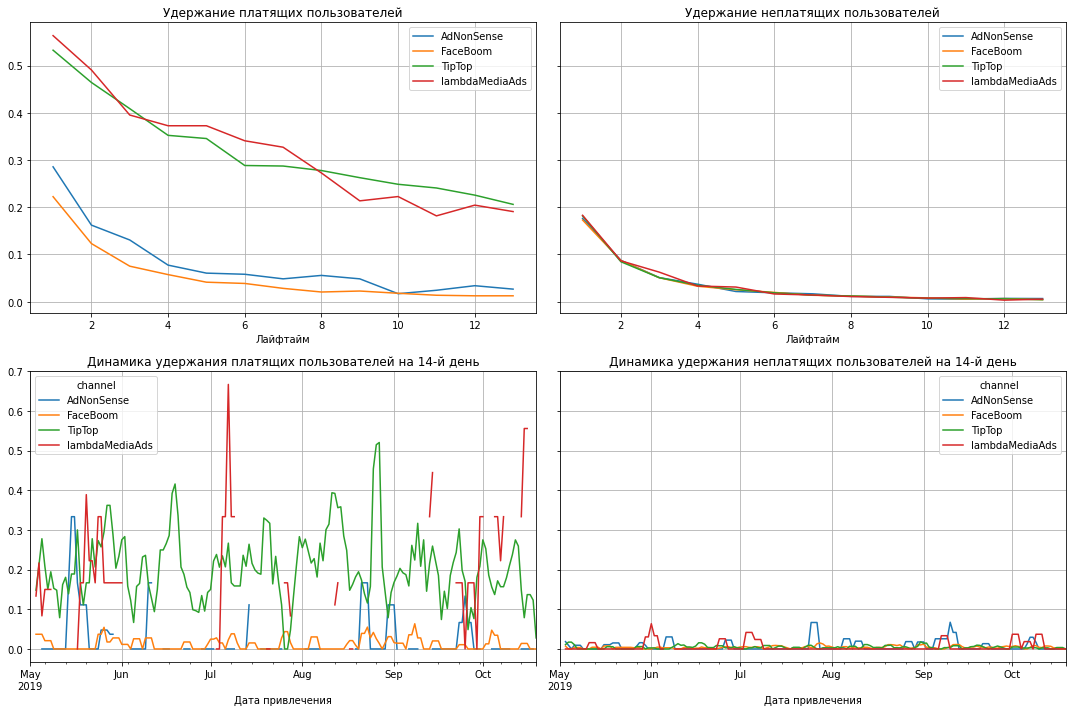

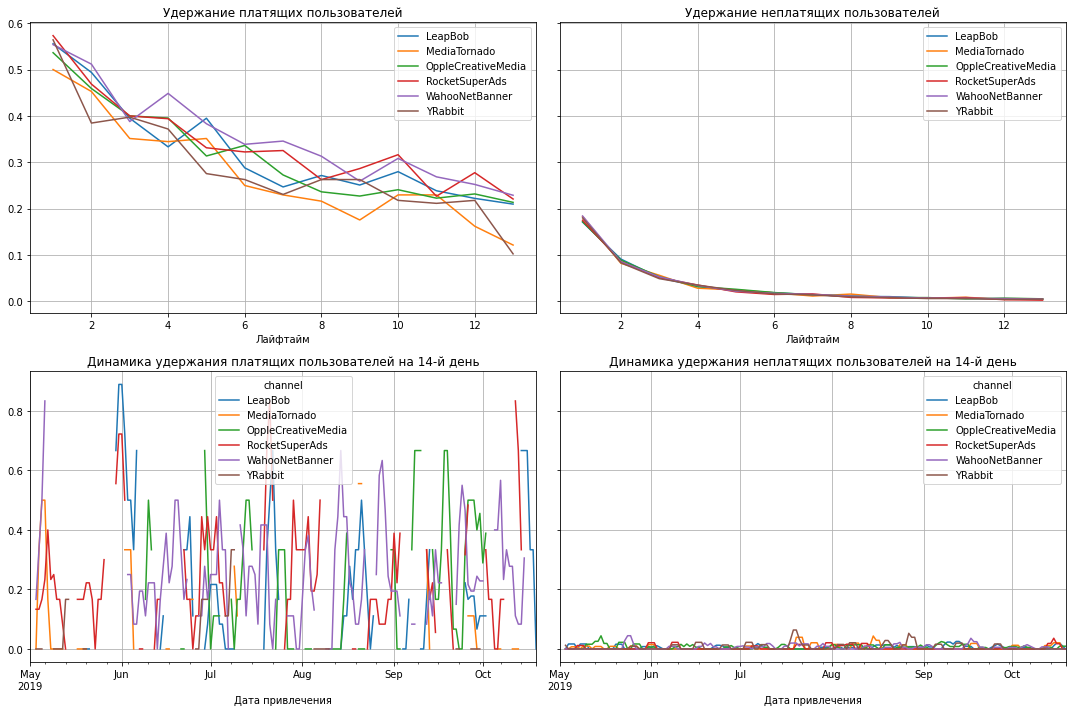

In [82]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы удержания первой кагорты
retention_raw1, retention1, retention_history1 =  get_retention(profiles_с1, visits, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention1, retention_history1, horizon_days)
#получаем таблицы удержания второй кагорты
retention_raw2, retention2, retention_history2 =  get_retention(profiles_с2, visits, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention2, retention_history2, horizon_days)

Мы видим, что пользователи, привлекаемые FaceBoom и AdnonSense крайне плохо удерживаются. Динамика этих каналов остается низкой на протяжении всего периода. В это же время пользователи, привлеченные из других каналов удерживаются заметно лучше. Их динамика не стабильна и очень схожа друг с другом. С чем это может быть связано? Возможно здесь снова играет роль регион. Посмотрим на сгруппированные данные. 

Попробуем сначала найти зависимость между типом устройства и каналом привлечения.

In [83]:
#считаем количество посетителей для каждого устройства и канала
profiles.groupby(['device', 'channel']).agg({'user_id':'count'}).sort_values(by=['device', 'user_id'], ascending = False)

user_id
device  channel                    
iPhone  FaceBoom              12996
        TipTop                 8840
        MediaTornado           1927
        RocketSuperAds         1917
        YRabbit                1868
        WahooNetBanner         1711
        OppleCreativeMedia     1701
        LeapBob                1691
        AdNonSense              798
        lambdaMediaAds          433
PC      OppleCreativeMedia     3496
        WahooNetBanner         3409
        LeapBob                3402
        FaceBoom               3008
        TipTop                 2012
        AdNonSense             1563
        lambdaMediaAds          862
        YRabbit                 482
        RocketSuperAds          466
        MediaTornado            453
Mac     FaceBoom               7265
        TipTop                 4820
        RocketSuperAds         1137
        MediaTornado           1105
        YRabbit                1097
        OppleCreativeMedia      882
        LeapBob                 880
        WahooNetBanner          856
        AdNonSense              410
        lambdaMediaAds          241
Android FaceBoom               5875
        TipTop                 3889
        LeapBob                2580
        WahooNetBanner         2577
        OppleCreativeMedia     2526
        AdNonSense             1109
        RocketSuperAds          928
        MediaTornado            879
        YRabbit                 865
        lambdaMediaAds          613

На первый взгляд нет никаких намеков на зависимость. Каналы примерно равномерно распределены для каждого типа устройств. Посмотрм, как обстоит дело у удержания.

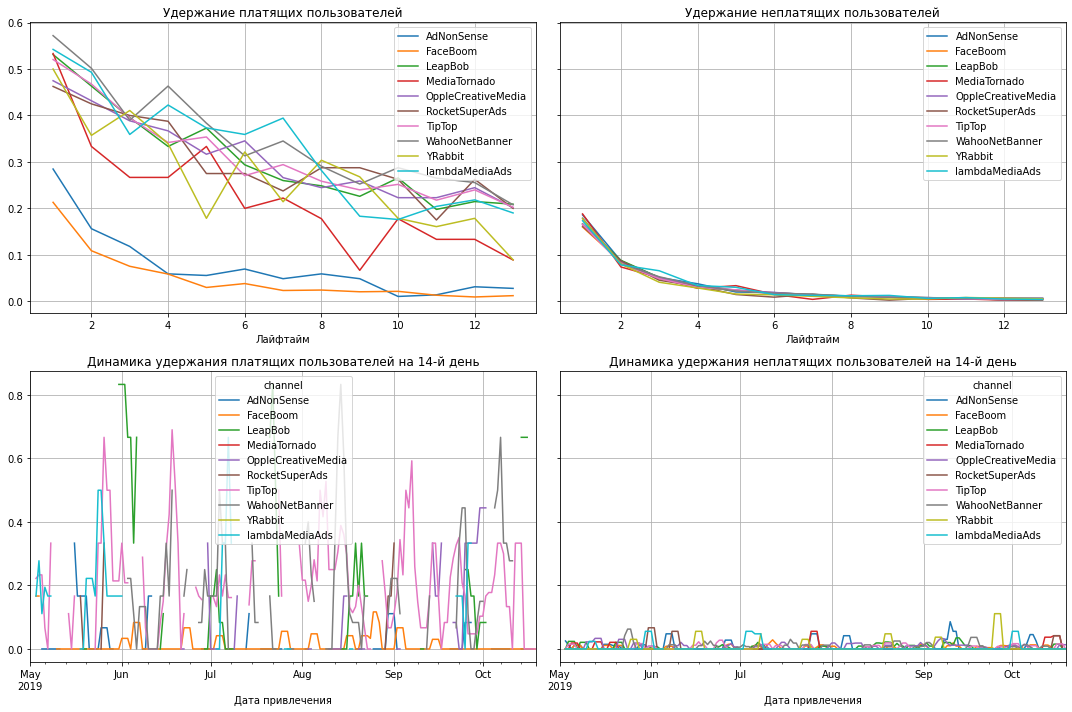

In [84]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles3, visits3, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Результат остался неизменным. Значит, тип устроства все-таки не виноват в низком удержании. Посмотрим на распределение по регионам.

In [85]:
#считаем количество посетителей для каждой страны и канала
profiles.groupby(['region', 'channel']).agg({'user_id':'count'}).sort_values(by=['region', 'user_id'], ascending = False)

user_id
region        channel                    
United States FaceBoom              29144
              TipTop                19561
              RocketSuperAds         4448
              MediaTornado           4364
              YRabbit                4312
UK            OppleCreativeMedia     3052
              LeapBob                3046
              WahooNetBanner         3003
              AdNonSense             1295
              lambdaMediaAds          758
Germany       WahooNetBanner         2579
              OppleCreativeMedia     2562
              LeapBob                2519
              AdNonSense             1219
              lambdaMediaAds          649
France        OppleCreativeMedia     2991
              LeapBob                2988
              WahooNetBanner         2971
              AdNonSense             1366
              lambdaMediaAds          742

Зависимость между регионами и каналом привлечения есть! Некотоыре каналы привлечения характерны только для определенных регионов. Уберем США из анализа и проверим, что у нас получится.

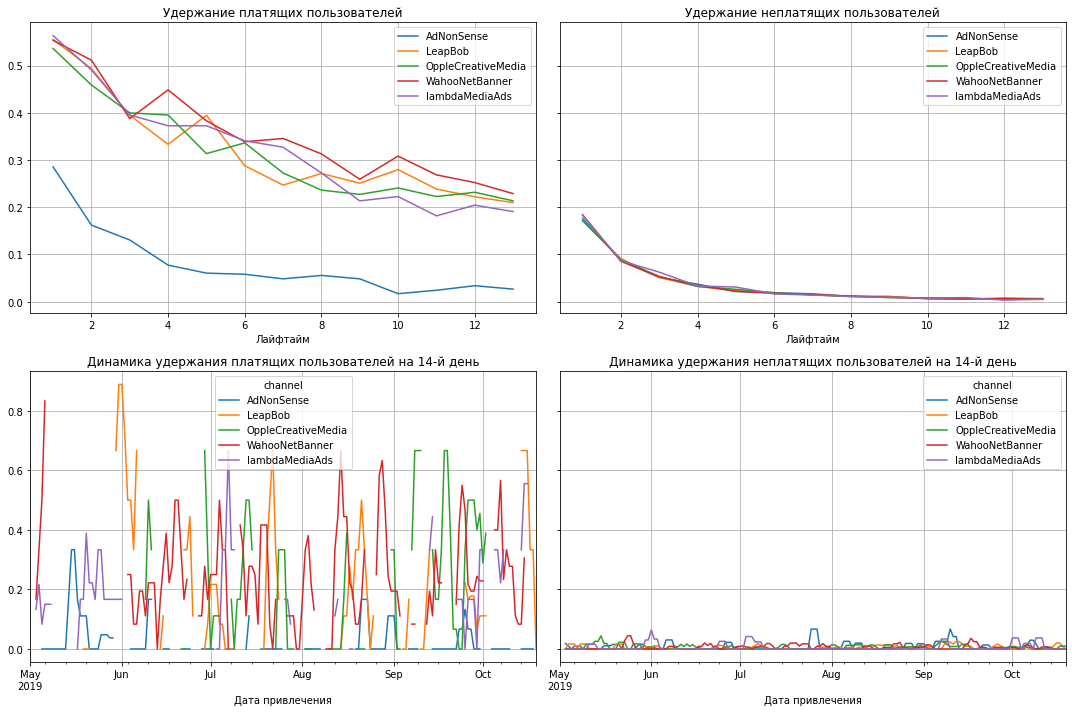

In [86]:
#задаем разбивку
dimensions = ['channel']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles2, visits2, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

США ушли, но вместе с ними и большиство источников заявило о своем уходе. Однако один проблемный канал все-таки остался. Значит, дело не в регионе, а именно в канале. Уберем каналы FaceBoom и AdNonSense по причине их плохого удержания и канал TipTop по причине его нерентабельности, объясняемой безумно большими расходами на привлечение пользователя и средним LTV, который приносят куда менее дорогие источники.

In [87]:
#убираем пользователей из убыточных каналов
profiles4 = profiles.query('channel != "AdNonSense" and channel != "FaceBoom" and channel != "TipTop"')
visits4 = visits.query('channel != "AdNonSense" and channel != "FaceBoom" and channel != "TipTop"')

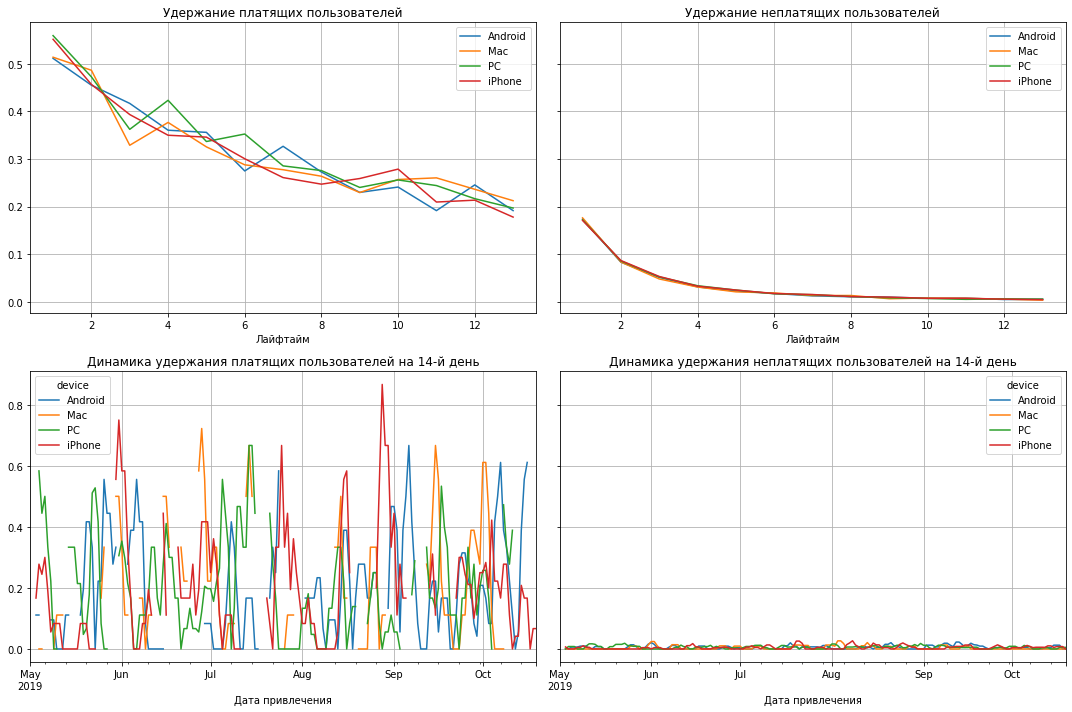

In [88]:
#задаем разбивку
dimensions = ['device']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles4, visits4, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Удержание пользователей продукции Apple стало более высоким. Посмотрим на окупаемость.

<Figure size 1440x720 with 0 Axes>

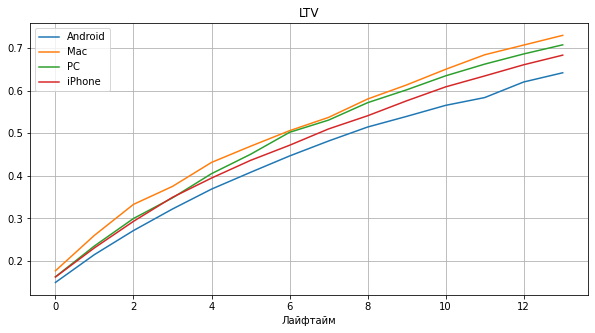

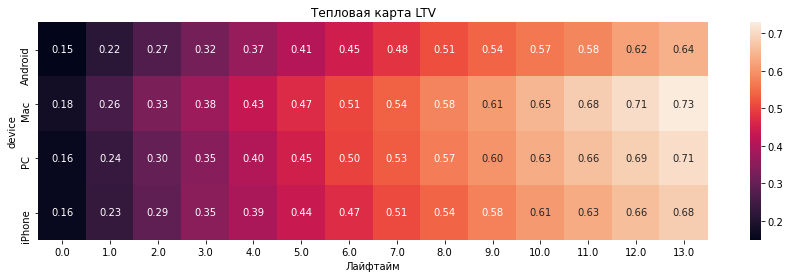

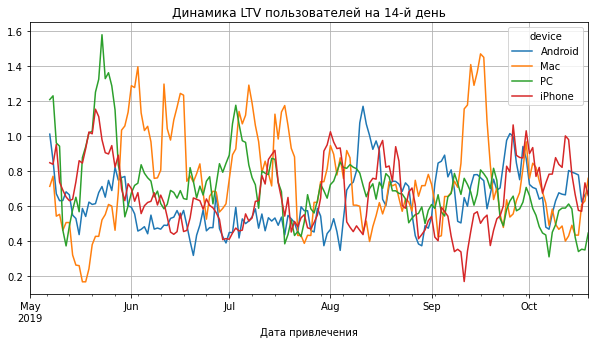

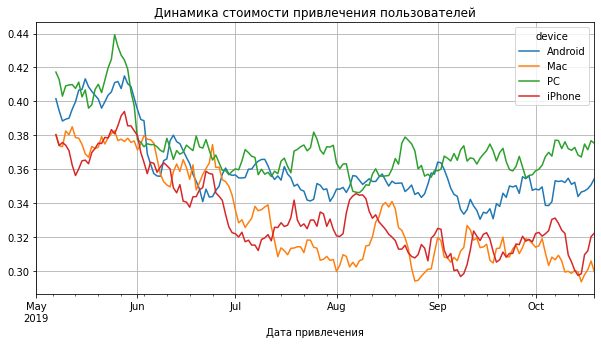

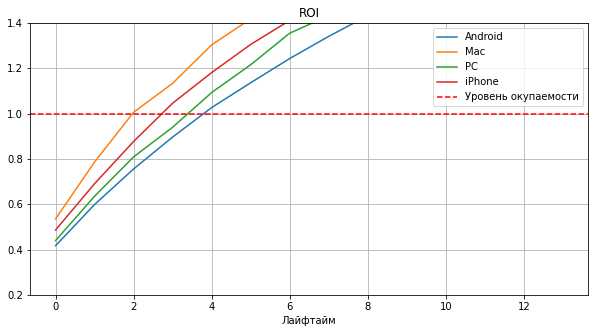

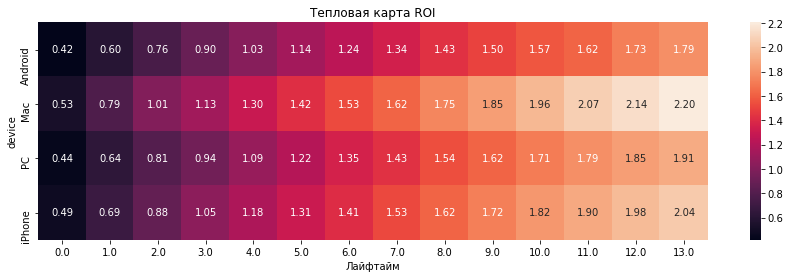

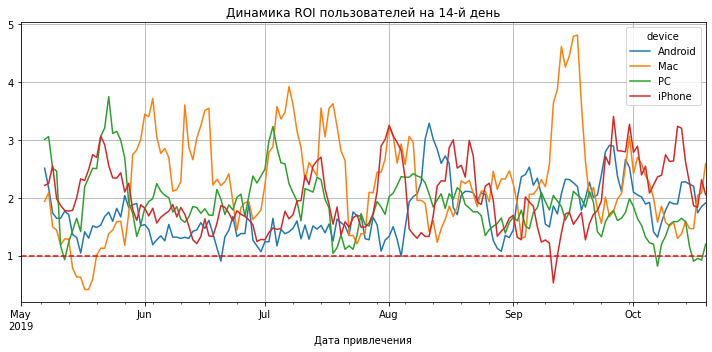

In [89]:
#задаем разбивку
dimensions = ['device']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles4, orders, observation_date, horizon_days, dimensions)
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Теперь пользователи всех устройств окупились. Посмотрим, как обстоят дела со странами. Расходы же на Mac и iPhone стали намного ниже, а общие расходы стали уменьшаться. Следовательно большая часть всех доходов приходилась именно на те 3 источника.

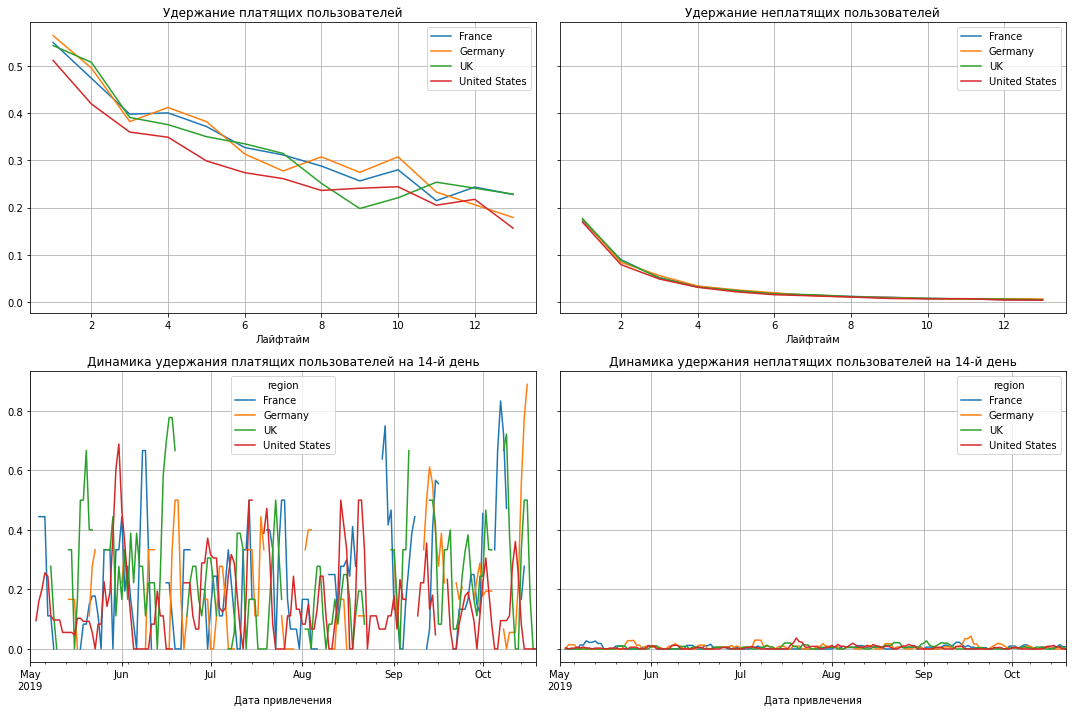

In [90]:
#задаем разбивку
dimensions = ['region']
#получаем таблицы удержания
retention_raw, retention, retention_history =  get_retention(profiles4, visits4, observation_date, horizon_days, dimensions)
#визуализируем таблицы удержания
plot_retention(retention, retention_history, horizon_days)

Удержание пользователей из США возросло в разы. Посмотрим на окупаемость.

<Figure size 1440x720 with 0 Axes>

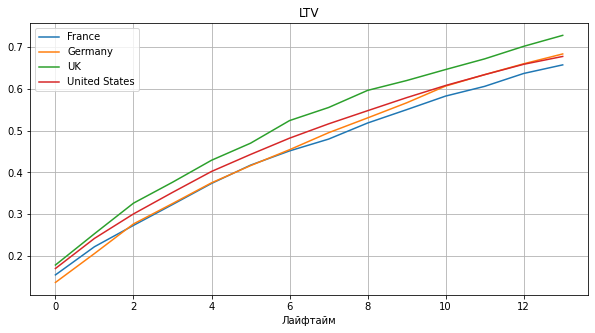

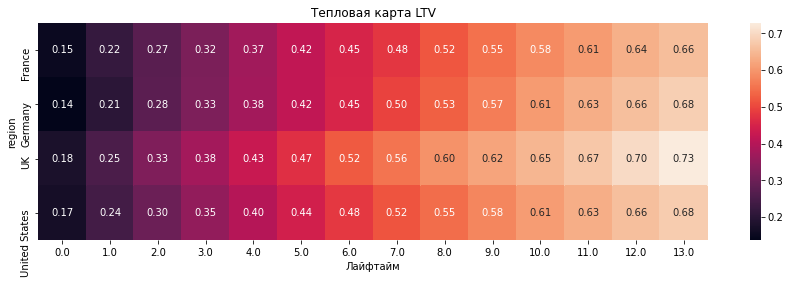

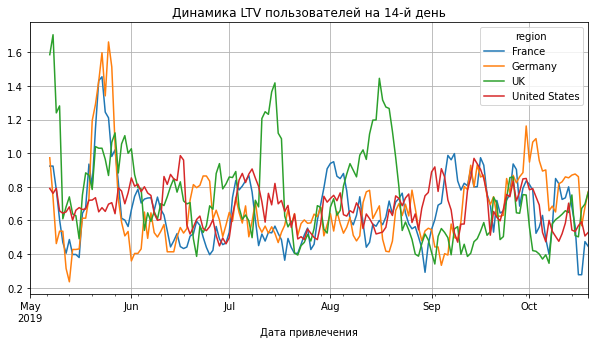

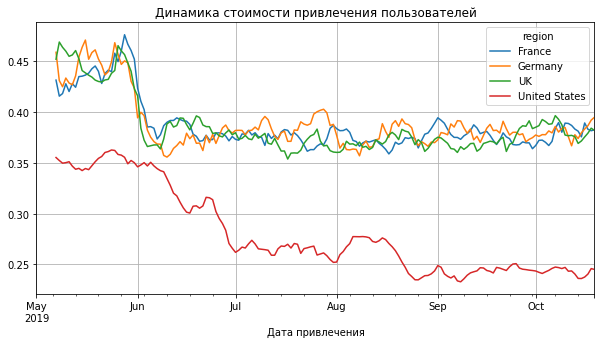

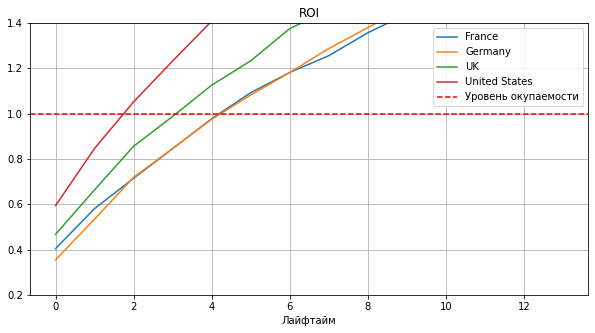

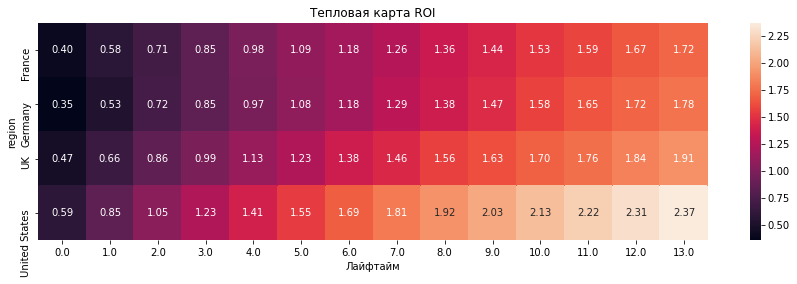

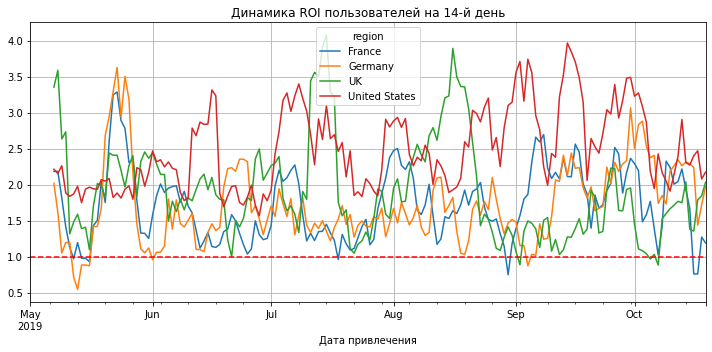

In [91]:
#задаем разбивку
dimensions = ['region']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles4, orders, observation_date, horizon_days, dimensions)
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Пользователи из США стали самыми окупаемыми. Делаем вывод - источники приводили к проблемам с окупаемостью. При этом стоимость привлечения пользователей в США упала в разы, расходы других стран так же стали меньше!

Посмотрим,как обстоят дела с каналами привлечения.

<Figure size 1440x720 with 0 Axes>

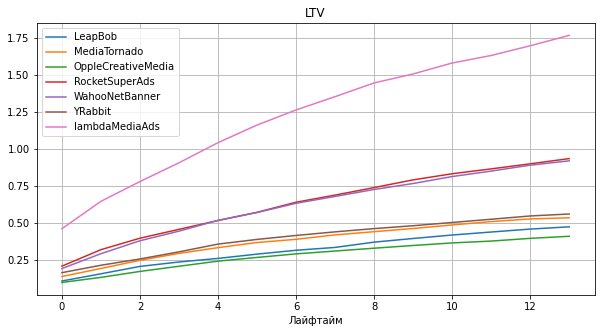

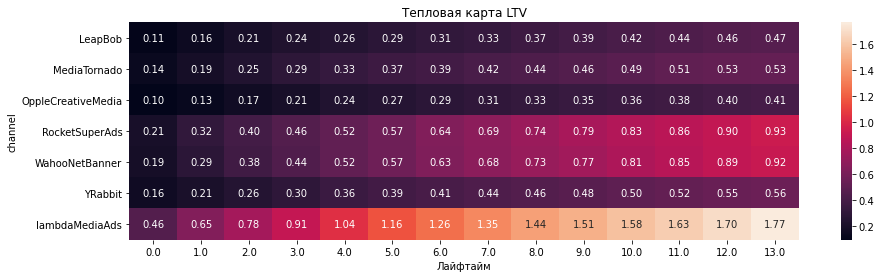

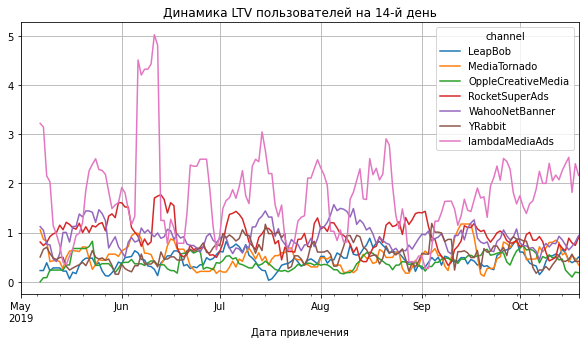

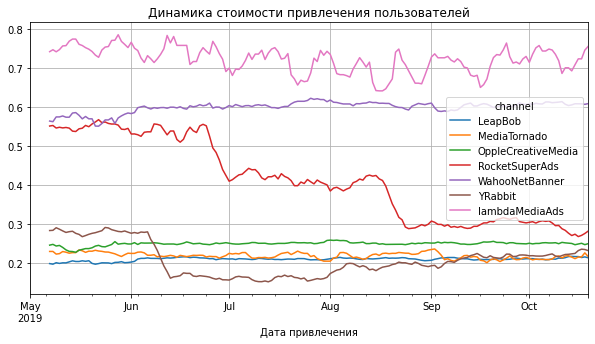

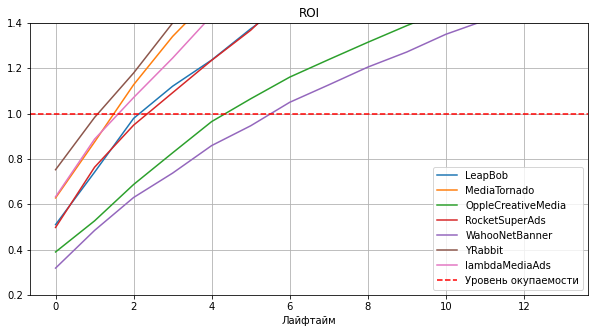

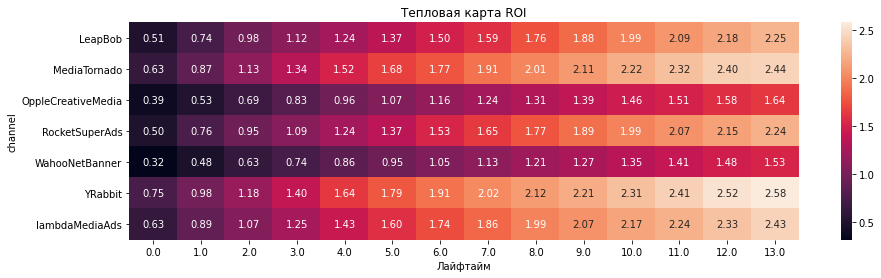

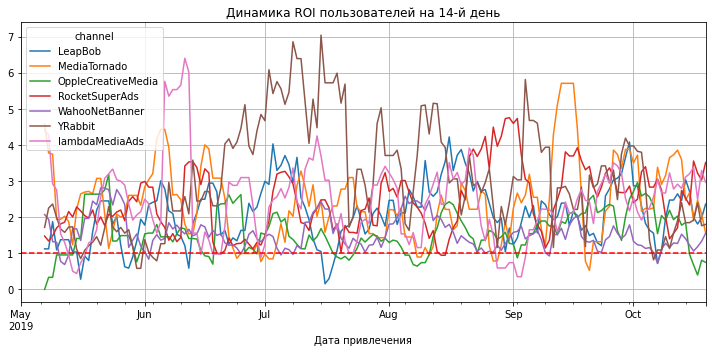

In [92]:
#задаем разбивку
dimensions = ['channel']
#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles4, orders, observation_date, horizon_days, dimensions)
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Все каналы окупились. Нет заметно высоких расходов.

## Проверка гипотезы

Теперь посмотрим на общую окупаемость без данных источников

<Figure size 1440x720 with 0 Axes>

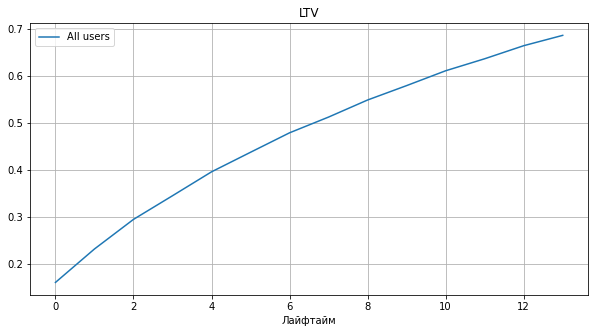

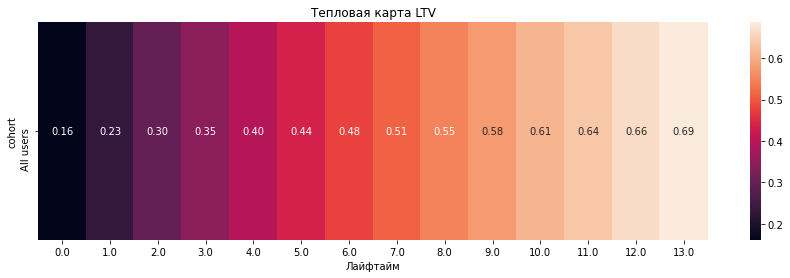

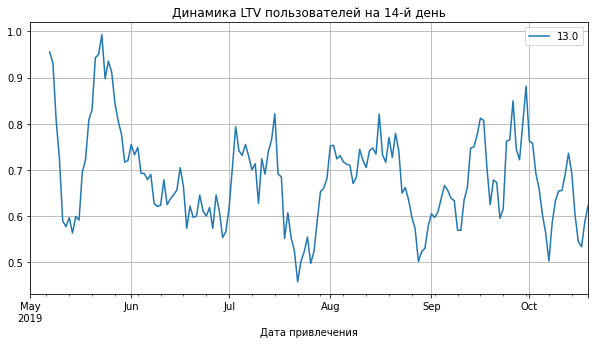

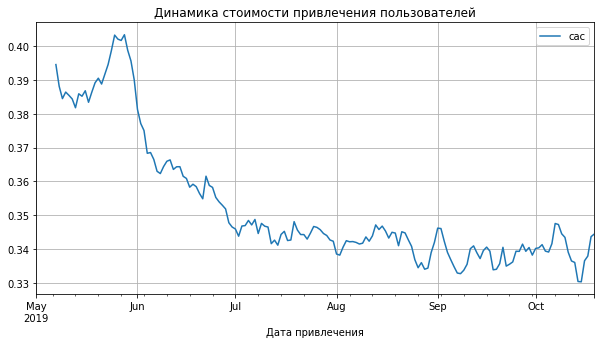

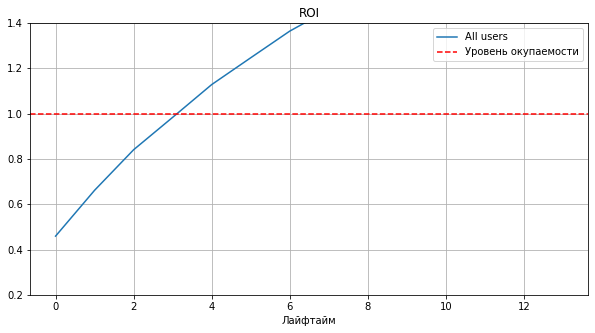

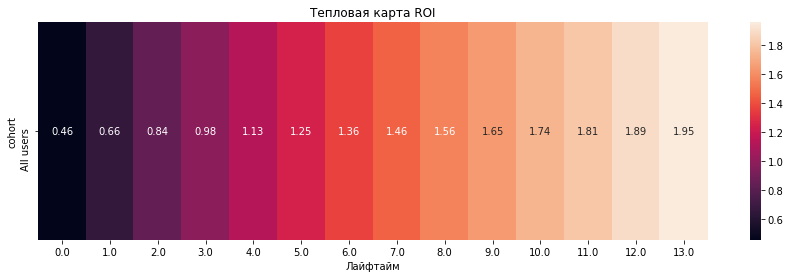

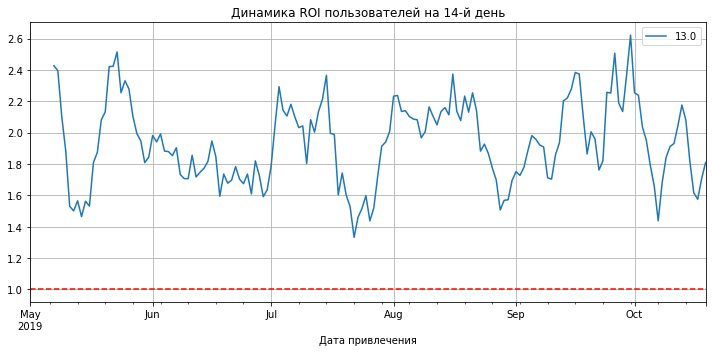

In [93]:

#получаем сырые данные, таблицу LTV, таблицу динамики LTV, таблицу ROI, таблицу динамики ROI
ltv_row_device, ltv_device, ltv_history_device,  roi_device, roi_history_device = get_ltv(profiles4, orders, observation_date, horizon_days)
#применяем функцию
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

Без использования данных источников привлечения приложение стало окупаться в 2 раза и, как правило, окупаемость происходит на 3 день жизни!

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

В ходе выполнения работы был проделан анализ, в ходе которого мы:
    
1) Выделили причины неэффективности привлечения пользователей:

К ним можно отнести использование неэффективных каналов привлечения пользователей. 
* Среди них можно выделить TipTop, который стоил больших денег и с каждым месяцем вливания в него становились все больше. При этом по LTV он уступал более дешевому источнику - lambdaMediaAds. Слишком большие затраты на данный источник приводили к тому, что доходы, получаемые от него не могли превысить расходы. Этот источник утаскивал вниз за собой окупаемость пользователей из США и пользователей Mac и Apple. При этм конверсия и удержание пользователей из этого источника особо не отличались от данных показателей у других источников. Следовательно, он не стоит таких больших вливаний
* Также можно выделить такие источники как AdNonSense и FaceBoom. Данные источники имели довольно высокую конверсию, высокий уровень LTV, привлечение пользователей через них стоит не так дорого. Однако пользователи, которые привлекаются из данных источников по неизвестным причианам крайне низкий, в следствие чего их окупаемость тоже низкая.

Также к ним можно отнести нецелесообразное расходование рекламных средств. Большое количество денег по необъяснимым причинам вливалось именно в эти каналы, которые в большинстве своем были представлены лишь в США. То есть, огромное количество денежных средств вливалось в определенные каналы привлечения без какого-либо дробления и логики. После удаления их из датасета мы увидили, что рекламные расходы США только падали. Также была привязка к продукции Apple данных каналов. После их удаления рекламные вливания для продукции Apple резко сократились.

2) Сформировали рекомендации для отдела маркетинга для повышения эффективности:
    
К таким рекомендациям можно отнести следующие:

* Либо полностью прекратить сотрудничество с рекламным каналом TipTop, либо пересмотреть условия соглашения с ним. Данный канал привлечения пользователей является необоснованно дорогим (самым дорогим) и самым неокупаемым.
* Разобраться с каналами AdNonSense и FaceBoom и понять, почему у них такое низкое удержание пользователей. Возможно данные ресурсы как-либо хитрят. В любом случае, по неизвестным причинам удержание у них низкое, а конверсия довольно высокая.
* Высвободившиеся денежные средства направить на рекламу других каналов. В частности, наиболее перспективными кажутся MediaTornado, YRabbit иlambdaMediaAds, денежные вливания в которые можно было бы увеличить. 
* Также без указанных ранее каналов выясняется, что рекламные расходы на привлечение пользователей Mac и iPhon ниже, чем у Android и PC, поскольку привлечение пользователей для этих типов устройств в большинстве своем происходило через неокупаемые каналы. Поэтому нужно будет увеличить вливания для привлечения пользователей данных устройств. Ведь они являются наиболее перспективными. То же самое можно сказать и про США, расходы на рекламу в которых скатились до минимальной планки при исключении данных устройств. Данные кагорты являются двольно перспективными и самыми окупаемыми - нужно поддерживать эти направления.